In [1]:
#!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git#egg=polara

In [2]:
#!pip install implicit

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "8" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "8"

## Imports

In [3]:
import io
import os
import gzip
import json
import scipy
import random
import warnings
import numpy as np
#import numba as nb
import pandas as pd
import datetime as dt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as st
from collections import OrderedDict
import scipy.sparse as sparse
from scipy.linalg import orth
import matplotlib.pyplot as plt
from numpy import linalg as lin
import implicit
import pickle
warnings.filterwarnings('ignore')
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from datetime import datetime as dt_dt
from scipy.sparse.linalg import spsolve
from numpy.linalg import qr as QR_decomp
from scipy.sparse import csr_matrix, find
from pandas.api.types import CategoricalDtype
from typing import List
import torch
import torch.nn.functional as F
from torch import nn
from polara.evaluation.pipelines import random_grid
import bottleneck as bn

## Functions

In [4]:
import sys
sys.path.append('/home/oolaleke/incremental_PSI/Scripts/')
#sys.path.append('/content/')

In [5]:
import a_DataHelpers
import b_AlgoFunctions
import c_PredEval
import d_CorrScores
import e_VAEfunction

In [7]:
from a_DataHelpers import getPivotMonths,Time_DataSplit,TestTrain_DataSplit,SingleRatingMatrix
from a_DataHelpers import AllRatingMatrices,All_SingleStepRatMat,psiStep_RatMat,psiAllStep_RatMat
from a_DataHelpers import Find_NewUsersItems,adjustedPSI_DF,adjustedAllDF,get_NEWHoldout,ADJUST_mainDF
from a_DataHelpers import  SingleStepRatMat_2,AllSingleStepRatMat_2,SingleStep_RatMat

from b_AlgoFunctions import integrator,getStartingValues,integratorOnMat,last_psiTrainMat, pureSVD
from b_AlgoFunctions import Updt_RowMatrix,getRow_Mat,row_update, Updt_ColMatrix,getCol_Mat,colunm_update
from b_AlgoFunctions import UsersItems_RatPair,getRowCol_psiupdt,ITEMS_defferredStatus,USERS_defferredStatus
from b_AlgoFunctions import getV_listUpdate, SingleStep_UPDATE,ALLSTEPs_UPDATE
from b_AlgoFunctions import tune_ALS,auc_score,TrainTest,mean_auc
from b_AlgoFunctions import nonzeros,least_squares_cg,alternating_least_squares_cg


from c_PredEval import TopNPred,TQDMgetALLTopNPred, Hitrate_Eval,getAll_HitRate,mean_confidence_interval
from c_PredEval import TQDMgetALLTopNPred_ALLUSERS,getALLTopNPred_ALLUSERS,get_ALLRandPred
from c_PredEval import topN_Index,getAll_RandomHitRate,getMOSTPOP_Pred,getAll_MostPOPHitRate,getAll_MOSTPOP_Pred
from c_PredEval import StepCoverage_Ratio,AllSteps_Coverage_Ratio,getAll_VAEMRR
from c_PredEval import MRR_Eval,getAll_MRR_Eval,TQDMgetAll_MRR_Eval, getAll_MostPOP_MRR,getAll_RandomRecMRR
from c_PredEval import ials_TopNPred, ials_getALLPred, ials_getALLPredTQDM,ialsALLPred_ALLUSERS

from d_CorrScores import no_copy_csr_matrix,build_rank_weights_matrix,rank_weighted_jaccard_index
from d_CorrScores import Updt_getAll_AvgCorr, updtCorr_4AllRanks

from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat


## Apply Functions on *AmazonGAMES*

###Import Clean Data 

In [9]:
#AMZGames_DF = pd.read_csv('/content/newIncre_AMGDF.csv') 
AMZGames_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_IncreDF.csv') 
AMZGames_DF['timestamp'] = pd.to_datetime(AMZGames_DF['timestamp']) 
print(AMZGames_DF.shape)   #userId_int
print(AMZGames_DF.dtypes)
AMZGames_DF

(345213, 7)
userid                  object
ProductID               object
rating                   int64
timestamp       datetime64[ns]
timestamp_YM            object
userId                   int64
productId                int64
dtype: object


,userid,ProductID,rating,timestamp,timestamp_YM,userId,productId
0,A2AXQTB83VMK4L,B0000296O5,1,1999-10-14,1999-10,0,0
1,A2T04VAIXSKJH2,B00002NDRY,1,1999-11-05,1999-11,1,1
2,A1QA8K3LD9K892,B000021Y5F,1,1999-11-10,1999-11,2,2
3,A1QA8K3LD9K892,B000021Y5Q,1,1999-11-10,1999-11,2,3
4,ANLA598UNJI8A,B00001IVGE,1,1999-11-14,1999-11,3,4
...,...,...,...,...,...,...,...
345208,AXGJNBYPUNR2,B01FDA42PU,1,2018-09-29,2018-09,29226,16596
345209,ANS2OWH7CK1M9,B01GW8YDLK,1,2018-09-30,2018-09,3543,17319
345210,A1SDXNTHJ255P7,B01GW3H3U8,1,2018-10-01,2018-10,33517,16745
345211,A3R7Y70K7ZPJ3I,B01GKF824Y,1,2018-10-01,2018-10,35953,17045


In [10]:
print(AMZGames_DF.shape)
print("For users: ")
print(AMZGames_DF['userId'].nunique())
print(AMZGames_DF['userId'].max())
print()
print("For items: ")
print(AMZGames_DF['productId'].nunique())
print(AMZGames_DF['productId'].max())
print()
print("Timestamp")
print(AMZGames_DF['timestamp'].min())
print(AMZGames_DF['timestamp'].max())

(345213, 7)
For users: 
39284
39283

For items: 
17320
17319

Timestamp
1999-10-14 00:00:00
2018-10-02 00:00:00


### Data Splitting

In [11]:
train_df = AMZGames_DF[AMZGames_DF['timestamp_YM'] < '2015-06']  
print(train_df['userid'].nunique())
print(train_df['userid'].shape)  ##63%

30238
(217772,)


In [12]:
remainder_df = AMZGames_DF[AMZGames_DF['timestamp_YM'] >= '2015-06']  
print(remainder_df['userid'].nunique())
print(remainder_df.shape)

23371
(127441, 7)


In [13]:
AMZGames_DF['userId']  #.unique()

n = 5550  #num_of_interaction/no_steps
all_df = []
for g, df in remainder_df.groupby(np.arange(len(remainder_df)) // n):
    all_df.append(df)
    print(df['userId'].nunique())
print()
print(g+1)    

2255
2215
2236
2293
2336
2362
2176
2225
2239
2408
2346
2259
2275
2290
2374
2311
2228
2269
2330
2302
2297
2294
2232

23


In [14]:
A0_df = train_df  
print("Initial Training Data: ") 
print("Start Time: ",A0_df['timestamp'].min())
print("End Time:   ",A0_df['timestamp'].max())
print()
print("Num of interactions: ",A0_df.shape[0])
print("Num of uniqueUsers:  ",A0_df['userId'].nunique())

Initial Training Data: 
Start Time:  1999-10-14 00:00:00
End Time:    2015-05-31 00:00:00

Num of interactions:  217772
Num of uniqueUsers:   30238


In [15]:
ΔA_train = all_df[:8] 
print("Incremental Train steps: ",len(ΔA_train))
print("Start Time: ",ΔA_train[0]['timestamp'].min())
print("End Time:   ",ΔA_train[-1]['timestamp'].max())

Incremental Train steps:  8
Start Time:  2015-06-01 00:00:00
End Time:    2016-02-14 00:00:00


In [16]:
ΔA_test = all_df[8:] 
print("Incremental Test steps: ",len(ΔA_test))
print("Start Time: ",ΔA_test[0]['timestamp'].min())
print("End Time:   ",ΔA_test[-1]['timestamp'].max())

Incremental Test steps:  15
Start Time:  2016-02-14 00:00:00
End Time:    2018-10-02 00:00:00


In [17]:
ΔA_test[0]['timestamp'].max()

Timestamp('2016-03-13 00:00:00')

In [18]:
AllDF_list, PSITest_list, HOLDOUT_list,UserItemDF_list = TestTrain_DataSplit(AMZGames_DF,'userId','timestamp',ΔA_test)
print(AllDF_list[1]['timestamp'].min())
print(AllDF_list[1]['timestamp'].max())
print()
print(ΔA_test[1]['timestamp'].min())
print(ΔA_test[1]['timestamp'].max())

1999-10-14 00:00:00
2016-04-19 00:00:00

2016-03-13 00:00:00
2016-04-19 00:00:00


In [19]:
for i in range(10):
    print(AllDF_list[i]['userId'].max(),AllDF_list[i]['userId'].nunique())

34705 34706
35124 35125
35482 35483
35886 35887
36314 36315
36662 36663
37003 37004
37346 37347
37698 37699
38004 38005


In [20]:
print(AllDF_list[0].shape)
print(UserItemDF_list[0].shape)
print(HOLDOUT_list[0].shape)

(267723, 7)
(265446, 7)
(2239, 7)


### Find new users and items

In [21]:
Tstps = AMZGames_DF['timestamp']
tr_ts = ΔA_train[-1]['timestamp'].max()
print("ΔA_train_last max date: ",tr_ts)
AllDF_start = AMZGames_DF.loc[Tstps <= tr_ts] 
print(AllDF_start['timestamp'].min())
print(AllDF_start['timestamp'].max())
print()
print(AllDF_list[0]['timestamp'].min())
print(AllDF_list[0]['timestamp'].max())

ΔA_train_last max date:  2016-02-14 00:00:00
1999-10-14 00:00:00
2016-02-14 00:00:00

1999-10-14 00:00:00
2016-03-13 00:00:00


In [22]:
New_usersList,New_itemsList = Find_NewUsersItems(AllDF_start,AllDF_list,'userId','productId',N_steps=15)
print(New_usersList[0][:10]) #
print()
print(New_itemsList[0][:10]) #

[34250 34251 34252 34253 34254 34255 34256 34257 34258 34259]

[16034 16035 16036 16037 16038 16039 16040 16041 16042 16043]


In [23]:
print("users,Items")
for i,j in zip(New_usersList,New_itemsList):
    print(i.size,j.size)
    print()
    

users,Items
456 175

419 157

358 147

404 137

428 113

348 112

341 160

343 67

352 40

306 48

272 31

268 34

295 33

260 14

184 18



## Incre Update

###Get Updt RatMat

In [24]:
rows_i = AllDF_start['userId'].nunique()
cols_i = AllDF_start['productId'].nunique()
print(A0_df.shape)
A0_RatMat_updt = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)
A0_RatMat_updt

(217772, 7)


<34250x16034 sparse matrix of type '<class 'numpy.float64'>'
	with 203890 stored elements in Compressed Sparse Row format>

In [25]:
PSI_TrainMat_updt = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_TrainMat_updt

[<34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5390 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5394 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5404 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5391 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5440 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5436 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5439 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5431 stored elements in Compressed Sparse Row format>]

### Allsteps Update

In [ ]:
# rows_i = AllDF_start['userId'].nunique()
# cols_i = AllDF_start['productId'].nunique()
# print(AllDF_start.shape)
# AllDF_startRatMat = SingleRatingMatrix(AllDF_start,'userId', 'productId',rows_i,cols_i)

# U_start,S_start,V_start = svds(AllDF_startRatMat,k=50)
# V_start = V_start.T
# print()
# print("U_start shape: ",U_start.shape)
# print("S_start shape: ",S_start.shape)
# print("V_start shape: ",V_start.shape)

In [26]:
U_start,S_start,V_start = last_psiTrainMat(A0_RatMat_updt,PSI_TrainMat_updt,k=80)
print()
print("U_start shape: ",U_start.shape)
print("S_start shape: ",S_start.shape)
print("V_start shape: ",V_start.shape)

100%|██████████| 8/8 [00:00<00:00,  9.57it/s]
U_start shape:  (34250, 80)
S_start shape:  (80, 80)
V_start shape:  (16034, 80)



In [27]:
U_list,S_list,V_list = [],[],[]
U_list.append(U_start)
S_list.append(S_start)
V_list.append(V_start)
print(len(U_list),len(V_list))

1 1


In [28]:
DItems_, DUsers_,In_DomainUSERS,In_DomainITEMS,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,U_list,S_list,V_list = ALLSTEPs_UPDATE(AllDF_start,UserItemDF_list,New_itemsList,New_usersList,U_list,S_list,V_list,'userId','productId',Nsteps=15,k=80,Forced_Orth=False)

100%|██████████| 14/14 [03:22<00:00, 14.44s/it]


### Output Check

In [29]:
print(AllDF_start['productId'].max())
print(AllDF_start['userId'].max())

16033
34249


In [30]:
print(len(In_DomainITEMS[16033+1:]))
print(In_DomainITEMS[16033+1:][:10])
print()
print(len(In_DomainUSERS[34249+1:]))
print(In_DomainUSERS[34249+1:][:10])

1284
[16034, 16035, 16037, 16039, 16040, 16044, 16046, 16047, 16048, 16049]

5034
[34251, 34252, 34253, 34254, 34255, 34256, 34257, 34258, 34259, 34260]


In [31]:
#deferred items and users
print(len(DItems_))
print(DItems_[:10])
print()
print(len(DUsers_))
print(DUsers_[:10])

2
[17312, 17317]

0
[]


In [32]:
for x in list(itemID_dict)[16033+1:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  itemID_dict[x]))   ##id ==key || updtedid == values  ,itemID_dict

Id: 16034, UpdtId: 16034 
Id: 16035, UpdtId: 16035 
Id: 16037, UpdtId: 16036 
Id: 16039, UpdtId: 16037 
Id: 16040, UpdtId: 16038 
Id: 16044, UpdtId: 16039 
Id: 16046, UpdtId: 16040 
Id: 16047, UpdtId: 16041 
Id: 16048, UpdtId: 16042 
Id: 16049, UpdtId: 16043 
Id: 16050, UpdtId: 16044 
Id: 16051, UpdtId: 16045 
Id: 16052, UpdtId: 16046 
Id: 16054, UpdtId: 16047 
Id: 16055, UpdtId: 16048 
Id: 16056, UpdtId: 16049 
Id: 16058, UpdtId: 16050 
Id: 16061, UpdtId: 16051 
Id: 16062, UpdtId: 16052 
Id: 16065, UpdtId: 16053 
Id: 16067, UpdtId: 16054 
Id: 16068, UpdtId: 16055 
Id: 16069, UpdtId: 16056 
Id: 16070, UpdtId: 16057 
Id: 16072, UpdtId: 16058 
Id: 16073, UpdtId: 16059 
Id: 16074, UpdtId: 16060 
Id: 16075, UpdtId: 16061 
Id: 16076, UpdtId: 16062 
Id: 16077, UpdtId: 16063 
Id: 16078, UpdtId: 16064 
Id: 16079, UpdtId: 16065 
Id: 16080, UpdtId: 16066 
Id: 16082, UpdtId: 16067 
Id: 16083, UpdtId: 16068 
Id: 16085, UpdtId: 16069 
Id: 16087, UpdtId: 16070 
Id: 16089, UpdtId: 16071 
Id: 16090, U

In [33]:
for x in list(userID_dict)[34249:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  userID_dict[x]))   ##id ==key || updtedid == values 

Id: 34249, UpdtId: 34249 
Id: 34251, UpdtId: 34250 
Id: 34252, UpdtId: 34251 
Id: 34253, UpdtId: 34252 
Id: 34254, UpdtId: 34253 
Id: 34255, UpdtId: 34254 
Id: 34256, UpdtId: 34255 
Id: 34257, UpdtId: 34256 
Id: 34258, UpdtId: 34257 
Id: 34259, UpdtId: 34258 
Id: 34260, UpdtId: 34259 
Id: 34261, UpdtId: 34260 
Id: 34263, UpdtId: 34261 
Id: 34266, UpdtId: 34262 
Id: 34267, UpdtId: 34263 
Id: 34268, UpdtId: 34264 
Id: 34269, UpdtId: 34265 
Id: 34270, UpdtId: 34266 
Id: 34271, UpdtId: 34267 
Id: 34272, UpdtId: 34268 
Id: 34273, UpdtId: 34269 
Id: 34274, UpdtId: 34270 
Id: 34275, UpdtId: 34271 
Id: 34276, UpdtId: 34272 
Id: 34277, UpdtId: 34273 
Id: 34280, UpdtId: 34274 
Id: 34282, UpdtId: 34275 
Id: 34283, UpdtId: 34276 
Id: 34284, UpdtId: 34277 
Id: 34285, UpdtId: 34278 
Id: 34286, UpdtId: 34279 
Id: 34287, UpdtId: 34280 
Id: 34288, UpdtId: 34281 
Id: 34289, UpdtId: 34282 
Id: 34291, UpdtId: 34283 
Id: 34292, UpdtId: 34284 
Id: 34294, UpdtId: 34285 
Id: 34295, UpdtId: 34286 
Id: 34300, U

In [34]:
print(len(U_list),len(V_list))
print(U_list[0].shape,V_list[0].shape)
print()
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape,v.shape)   

16 16
(34250, 80) (16034, 80)

(34576, 80) (16139, 80)
(35003, 80) (16295, 80)
(35393, 80) (16441, 80)
(35799, 80) (16570, 80)
(36209, 80) (16706, 80)
(36585, 80) (16820, 80)
(36929, 80) (16968, 80)
(37279, 80) (17072, 80)
(37644, 80) (17119, 80)
(37952, 80) (17162, 80)
(38235, 80) (17201, 80)
(38518, 80) (17235, 80)
(38811, 80) (17271, 80)
(39089, 80) (17293, 80)
(39284, 80) (17318, 80)


In [35]:
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

34576 16139
35003 16295
35393 16441
35799 16570
36209 16706
36585 16820
36929 16968
37279 17072
37644 17119
37952 17162
38235 17201
38518 17235
38811 17271
39089 17293
39284 17318


In [36]:
print(len(In_DomainUSERS),len(In_DomainITEMS))
print(AMZGames_DF['userId'].nunique(),AMZGames_DF['productId'].nunique())

39284 17318
39284 17320


Data Adjustments

### Data Adjustment

In [37]:
len(AllUpdtITEMS_)

15

In [38]:

newHOLDOUT_LIST = get_NEWHoldout(HOLDOUT_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(len(newHOLDOUT_LIST))
print()
for old,new in zip(HOLDOUT_list,newHOLDOUT_LIST):
    print(old.shape[0],new.shape[0])

15it [00:00, 58.42it/s]15

2239 2018
2408 2200
2346 2172
2259 2079
2275 2089
2290 2120
2374 2217
2311 2207
2228 2133
2269 2171
2330 2261
2302 2246
2297 2196
2294 2269
2232 2222



In [39]:
newUserItem_list = adjustedAllDF(UserItemDF_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print()
for df in newUserItem_list:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

15it [00:06,  2.33it/s]
34575 16138
35002 16294
35392 16440
35798 16569
36208 16705
36584 16819
36928 16967
37278 17071
37643 17118
37951 17161
38234 17200
38517 17234
38810 17270
39088 17292
39283 17317



In [40]:
new_PSIDFlist = adjustedPSI_DF(PSITest_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
for old,new in zip(PSITest_list,new_PSIDFlist):
    print(old.shape[0],new.shape[0])

15it [00:00, 53.45it/s]3311 3310
3142 3140
3204 3204
3291 3291
3275 3275
3260 3260
3176 3175
3239 3238
3322 3321
3281 3280
3220 3220
3248 3248
3253 3252
3256 3256
3109 3109



In [41]:
newAMZGames_DF = ADJUST_mainDF(AMZGames_DF,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(newAMZGames_DF.shape)
print(newAMZGames_DF['userId'].max(),newAMZGames_DF['productId'].max())
print(newAMZGames_DF['userId'].nunique(),newAMZGames_DF['productId'].nunique())
print()
print(newAMZGames_DF['Updated_UserID'].max(),newAMZGames_DF['Updated_ItemID'].max())
print(newAMZGames_DF['Updated_UserID'].nunique(),newAMZGames_DF['Updated_ItemID'].nunique())
#newAMZB_DF.head()

(345203, 9)
39283 17319
39284 17318

39283 17317
39284 17318


In [44]:
with open('AMZGames_newUserItem.pkl', 'wb') as f:
     pickle.dump(newUserItem_list, f)

with open('AMZGames_newHoldout.pkl', 'wb') as f:
     pickle.dump(newHOLDOUT_LIST, f)

with open('AMZGames_newPSITest.pkl', 'wb') as f:
     pickle.dump(new_PSIDFlist, f)     

In [53]:
newAMZGames_DF.to_csv('AMZGms_afterUpdt.csv',index=False)

In [46]:
with open('AMZGames_newPSITest.pkl', 'rb') as f:
     newPSITest_ = pickle.load(f)

In [65]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZGames_newHoldout.pkl', 'rb') as f:
     newHoldOut_ = pickle.load(f)
     
print(newPSITest_[0].shape)
print(newPSITest_[0]['Updated_UserID'].nunique())
# print(new_PSIDFlist[0].shape)
# print(new_PSIDFlist[0]['Updated_UserID'].nunique())

(3310, 4)
1062


### Get UserItem MAT

In [42]:
for i in range(10):
    print(newUserItem_list[i]['Updated_UserID'].max(),newUserItem_list[i]['Updated_ItemID'].max())

34575 16138
35002 16294
35392 16440
35798 16569
36208 16705
36584 16819
36928 16967
37278 17071
37643 17118
37951 17161


In [43]:
print(len(U_list[1:]),len(V_list[1:]))
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape[0],v.shape[0])   

15 15
34576 16139
35003 16295
35393 16441
35799 16570
36209 16706
36585 16820
36929 16968
37279 17072
37644 17119
37952 17162
38235 17201
38518 17235
38811 17271
39089 17293
39284 17318


In [45]:
                   #AllSingleStepRatMat_2(DFList,Ulist,Vlist,user_column,item_column)
UserItem_Matupdt = AllSingleStepRatMat_2(newUserItem_list,U_list[1:],V_list[1:],'Updated_UserID','Updated_ItemID')
print(len(UserItem_Matupdt))
UserItem_Matupdt

15


[<34576x16139 sparse matrix of type '<class 'numpy.float64'>'
 	with 250384 stored elements in Compressed Sparse Row format>,
 <35003x16295 sparse matrix of type '<class 'numpy.float64'>'
 	with 255520 stored elements in Compressed Sparse Row format>,
 <35393x16441 sparse matrix of type '<class 'numpy.float64'>'
 	with 261105 stored elements in Compressed Sparse Row format>,
 <35799x16570 sparse matrix of type '<class 'numpy.float64'>'
 	with 266597 stored elements in Compressed Sparse Row format>,
 <36209x16706 sparse matrix of type '<class 'numpy.float64'>'
 	with 272102 stored elements in Compressed Sparse Row format>,
 <36585x16820 sparse matrix of type '<class 'numpy.float64'>'
 	with 277572 stored elements in Compressed Sparse Row format>,
 <36929x16968 sparse matrix of type '<class 'numpy.float64'>'
 	with 282899 stored elements in Compressed Sparse Row format>,
 <37279x17072 sparse matrix of type '<class 'numpy.float64'>'
 	with 288493 stored elements in Compressed Sparse Row f

In [46]:
print(AllDF_start['userId'].nunique(),AllDF_start['productId'].nunique())
print()
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

34250 16034

34576 16139
35003 16295
35393 16441
35799 16570
36209 16706
36585 16820
36929 16968
37279 17072
37644 17119
37952 17162
38235 17201
38518 17235
38811 17271
39089 17293
39284 17318


### V_list

In [47]:
print(len(UserItem_Matupdt),len(newHOLDOUT_LIST))

15 15


In [48]:
Vpsi_listUpdt = V_list[1:]
for v in Vpsi_listUpdt:
    print(v.shape)

(16139, 80)
(16295, 80)
(16441, 80)
(16570, 80)
(16706, 80)
(16820, 80)
(16968, 80)
(17072, 80)
(17119, 80)
(17162, 80)
(17201, 80)
(17235, 80)
(17271, 80)
(17293, 80)
(17318, 80)


In [49]:
V_1 = Vpsi_listUpdt[0]
V_1.shape

(16139, 80)

### All Prediction

In [50]:
print(UserItem_Matupdt[0].shape)
UserItem_Matupdt[0]

(34576, 16139)


<34576x16139 sparse matrix of type '<class 'numpy.float64'>'
	with 250384 stored elements in Compressed Sparse Row format>

In [51]:
AllUsers_updtPRED =  TQDMgetALLTopNPred_ALLUSERS(UserItem_Matupdt,Vpsi_listUpdt, N=10) 
print(len(AllUsers_updtPRED))
AllUsers_updtPRED[:2]

15it [02:09,  8.66s/it]15



[array([[ 1434,   145,   385, ...,   687,   882,   284],
        [13491, 12905, 11924, ..., 13384, 14555, 12595],
        [  385,   145,     0, ...,   345,   958,  1801],
        ...,
        [ 4109, 11918,  4110, ...,  7304,  4735,  8239],
        [ 9827,  7963, 12905, ...,  6103,  9254,  7656],
        [10377,  4109, 11924, ...,  6771, 13857, 11961]]),
 array([[ 1434,   145,   385, ...,   687,   882,   284],
        [13491, 12905, 11924, ..., 13384, 14555, 12595],
        [  385,   145,     0, ...,   345,   958,  1801],
        ...,
        [12595, 10498, 12060, ..., 12073,  3827, 12062],
        [13491, 13171, 13825, ..., 12652, 13384, 12043],
        [ 9344,  4764,  4190, ...,  9880,  3442,  9592]])]

In [59]:
AllUsers_updtPRED[4].shape

(36209, 10)

In [61]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_UpdtPSI_allPRED.pkl', 'wb') as f:    
     pickle.dump(AllUsers_updtPRED, f)


In [ ]:
# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_UpdtPSI_AllPRED.pkl', 'rb') as f:
#      allpred_updt = pickle.load(f)
# print(len(allpred_updt))
# allpred_updt[:2]

In [ ]:
##iALS...

In [7]:
##lOAD Saved Lists...
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_newHoldout.pkl', 'rb') as f:
     newHOLDOUT_LIST = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)


with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_newPSITest.pkl', 'rb') as f:
     new_PSIDFlist = pickle.load(f)



In [9]:
newAMZGames_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_afterUpdt.csv')
print(newAMZGames_DF.shape)
print(newAMZGames_DF['userId'].max(),newAMZGames_DF['productId'].max())
print(newAMZGames_DF['userId'].nunique(),newAMZGames_DF['productId'].nunique())
print()
print(newAMZGames_DF['Updated_UserID'].max(),newAMZGames_DF['Updated_ItemID'].max())
print(newAMZGames_DF['Updated_UserID'].nunique(),newAMZGames_DF['Updated_ItemID'].nunique())
newAMZGames_DF.head()

(345203, 9)
39283 17319
39284 17318

39283 17317
39284 17318


,userid,ProductID,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
0,A2AXQTB83VMK4L,B0000296O5,1,1999-10-14,1999-10,0,0,0,0
1,A2T04VAIXSKJH2,B00002NDRY,1,1999-11-05,1999-11,1,1,1,1
2,A1QA8K3LD9K892,B000021Y5F,1,1999-11-10,1999-11,2,2,2,2
3,A1QA8K3LD9K892,B000021Y5Q,1,1999-11-10,1999-11,2,3,2,3
4,ANLA598UNJI8A,B00001IVGE,1,1999-11-14,1999-11,3,4,3,4


In [10]:
rows_i = newAMZGames_DF['Updated_UserID'].nunique()
cols_i = newAMZGames_DF['Updated_ItemID'].nunique()
Rating_matrix = SingleRatingMatrix(newUserItem_list[0],'Updated_UserID','Updated_ItemID',rows_i,cols_i)  #changes start within steps...
Rating_matrix

<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
	with 250384 stored elements in Compressed Sparse Row format>

In [11]:
als_params = dict(alpha = [ 0.001,0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
                  regularization = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10],
                  rank = list(range(10, 81, 10)),
                  iter_array = [10,15,20,25,30])

als_param_grid, als_param_names = random_grid(als_params, n=30)
print(als_param_names)
len(als_param_grid)                 

('alpha', 'regularization', 'rank', 'iter_array')


30

In [12]:
for i in range(10):
    alpha, reg, rank, iter = list(als_param_grid)[i]  
    print(alpha, reg, rank,iter)

50 0.01 10 20
1 0.05 30 15
0.5 10 80 25
50 1 50 15
0.001 0.005 30 20
0.05 0.05 40 20
100 0.1 50 20
5 0.01 20 25
0.001 0.001 30 25
0.5 0.005 60 20


In [16]:
train_set ,test_set,valid_set = TrainTest(Rating_matrix, pct_mask=0.2)
train_set

<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
	with 200307 stored elements in Compressed Sparse Row format>

In [17]:
best_model_Info = tune_ALS(train_set,test_set,valid_set,als_param_grid)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 1/30 [01:54<55:20, 114.49s/it]latent factors= 10 ,regularization = 0.01:, n_iter = 20, alpha = 50, AUC= 0.869085


  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 2/30 [04:03<57:19, 122.85s/it]latent factors= 30 ,regularization = 0.05:, n_iter = 15, alpha = 1, AUC= 0.794278


  0%|          | 0/25 [00:00<?, ?it/s]

 10%|█         | 3/30 [06:54<1:05:08, 144.76s/it]latent factors= 80 ,regularization = 10:, n_iter = 25, alpha = 0.5, AUC= 0.817006


  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [09:19<1:02:53, 145.15s/it]latent factors= 50 ,regularization = 1:, n_iter = 15, alpha = 50, AUC= 0.84543


  0%|          | 0/20 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [11:26<57:42, 138.48s/it]  latent factors= 30 ,regularization = 0.005:, n_iter = 20, alpha = 0.001, AUC= 0.739838


  0%|          | 0/20 [00:00<?, ?it/s]

 20%|██        | 6/30 [13:39<54:43, 136.80s/it]latent factors= 40 ,regularization = 0.05:, n_iter = 20, alpha = 0.05, AUC= 0.651992


  0%|          | 0/20 [00:00<?, ?it/s]

 23%|██▎       | 7/30 [16:01<53:01, 138.34s/it]latent factors= 50 ,regularization = 0.1:, n_iter = 20, alpha = 100, AUC= 0.851513


  0%|          | 0/25 [00:00<?, ?it/s]

 27%|██▋       | 8/30 [17:59<48:18, 131.76s/it]latent factors= 20 ,regularization = 0.01:, n_iter = 25, alpha = 5, AUC= 0.833621


  0%|          | 0/25 [00:00<?, ?it/s]

 30%|███       | 9/30 [20:05<45:34, 130.20s/it]latent factors= 30 ,regularization = 0.001:, n_iter = 25, alpha = 0.001, AUC= 0.709663


  0%|          | 0/20 [00:00<?, ?it/s]

 33%|███▎      | 10/30 [22:35<45:26, 136.33s/it]latent factors= 60 ,regularization = 0.005:, n_iter = 20, alpha = 0.5, AUC= 0.742791


  0%|          | 0/20 [00:00<?, ?it/s]

 37%|███▋      | 11/30 [25:14<45:20, 143.19s/it]latent factors= 70 ,regularization = 1:, n_iter = 20, alpha = 0.001, AUC= 0.441796


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 12/30 [27:05<39:57, 133.22s/it]latent factors= 10 ,regularization = 0.5:, n_iter = 20, alpha = 0.5, AUC= 0.794788


  0%|          | 0/20 [00:00<?, ?it/s]

 43%|████▎     | 13/30 [29:03<36:29, 128.79s/it]latent factors= 20 ,regularization = 10:, n_iter = 20, alpha = 50, AUC= 0.87067


  0%|          | 0/30 [00:00<?, ?it/s]

 47%|████▋     | 14/30 [31:52<37:35, 140.95s/it]latent factors= 80 ,regularization = 0.001:, n_iter = 30, alpha = 0.05, AUC= 0.693713


  0%|          | 0/15 [00:00<?, ?it/s]

 50%|█████     | 15/30 [34:30<36:28, 145.90s/it]latent factors= 70 ,regularization = 0.001:, n_iter = 15, alpha = 1, AUC= 0.764039


  0%|          | 0/25 [00:00<?, ?it/s]

 53%|█████▎    | 16/30 [36:38<32:47, 140.52s/it]latent factors= 30 ,regularization = 0.5:, n_iter = 25, alpha = 0.05, AUC= 0.708242


  0%|          | 0/20 [00:00<?, ?it/s]

 57%|█████▋    | 17/30 [38:45<29:34, 136.49s/it]latent factors= 30 ,regularization = 10:, n_iter = 20, alpha = 100, AUC= 0.868821


  0%|          | 0/15 [00:00<?, ?it/s]

 60%|██████    | 18/30 [41:25<28:41, 143.46s/it]latent factors= 70 ,regularization = 0.5:, n_iter = 15, alpha = 0.05, AUC= 0.731003


  0%|          | 0/15 [00:00<?, ?it/s]

 63%|██████▎   | 19/30 [43:54<26:39, 145.42s/it]latent factors= 60 ,regularization = 0.005:, n_iter = 15, alpha = 10, AUC= 0.822748


  0%|          | 0/25 [00:00<?, ?it/s]

 67%|██████▋   | 20/30 [46:11<23:46, 142.62s/it]latent factors= 40 ,regularization = 0.5:, n_iter = 25, alpha = 0.5, AUC= 0.7576


  0%|          | 0/25 [00:00<?, ?it/s]

 70%|███████   | 21/30 [48:19<20:45, 138.39s/it]latent factors= 30 ,regularization = 1:, n_iter = 25, alpha = 0.1, AUC= 0.745911


  0%|          | 0/30 [00:00<?, ?it/s]

 73%|███████▎  | 22/30 [50:52<19:01, 142.63s/it]latent factors= 60 ,regularization = 0.1:, n_iter = 30, alpha = 0.1, AUC= 0.672255


  0%|          | 0/10 [00:00<?, ?it/s]

 77%|███████▋  | 23/30 [53:15<16:39, 142.80s/it]latent factors= 50 ,regularization = 0.5:, n_iter = 10, alpha = 10, AUC= 0.824091


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 24/30 [55:12<13:31, 135.24s/it]latent factors= 20 ,regularization = 10:, n_iter = 20, alpha = 0.05, AUC= 0.573408


  0%|          | 0/25 [00:00<?, ?it/s]

 83%|████████▎ | 25/30 [57:28<11:16, 135.36s/it]latent factors= 40 ,regularization = 10:, n_iter = 25, alpha = 1, AUC= 0.812446


  0%|          | 0/25 [00:00<?, ?it/s]

 87%|████████▋ | 26/30 [1:00:00<09:21, 140.36s/it]latent factors= 60 ,regularization = 0.001:, n_iter = 25, alpha = 50, AUC= 0.84188


  0%|          | 0/20 [00:00<?, ?it/s]

 90%|█████████ | 27/30 [1:02:32<07:11, 143.86s/it]latent factors= 60 ,regularization = 0.1:, n_iter = 20, alpha = 50, AUC= 0.840467


  0%|          | 0/30 [00:00<?, ?it/s]

 93%|█████████▎| 28/30 [1:04:59<04:49, 144.63s/it]latent factors= 50 ,regularization = 0.05:, n_iter = 30, alpha = 1, AUC= 0.776283


  0%|          | 0/30 [00:00<?, ?it/s]

 97%|█████████▋| 29/30 [1:07:40<02:29, 149.76s/it]latent factors= 70 ,regularization = 0.001:, n_iter = 30, alpha = 0.05, AUC= 0.705804


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 30/30 [1:10:30<00:00, 141.00s/it]latent factors= 80 ,regularization = 0.005:, n_iter = 25, alpha = 100, AUC= 0.834284

 Best model; latent factors= 20 , regularization = 10, n_iter = 20, alpha = 50, AUC = 0.87067



In [18]:
best_model_Info

(20,
 10,
 20,
 50,
 0.87067,
 <implicit.als.AlternatingLeastSquares at 0x7fc88ccf8460>)

In [20]:
rows_i = newAMZGames_DF['Updated_UserID'].nunique()
cols_i = newAMZGames_DF['Updated_ItemID'].nunique()
UserItem_RatMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
UserItem_RatMAT

[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 250384 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 255520 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 261105 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 266597 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 272102 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 277572 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 282899 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 288493 stored elements in Compressed Sparse Row f

In [22]:
nuser_list = []
nItem_list = []
for df in  newUserItem_list:
    nuser_list.append(df['Updated_UserID'].max()+1)
    nItem_list.append(df['Updated_ItemID'].max()+1)

nuser_list = [0] + nuser_list  
nItem_list = [0] + nItem_list  

print(nuser_list)
print(nItem_list) 

[0, 34576, 35003, 35393, 35799, 36209, 36585, 36929, 37279, 37644, 37952, 38235, 38518, 38811, 39089, 39284]
[0, 16139, 16295, 16441, 16570, 16706, 16820, 16968, 17072, 17119, 17162, 17201, 17235, 17271, 17293, 17318]


In [25]:
#est model; latent factors= 20 , regularization = 10, n_iter = 20, alpha = 50, AUC = 0.87067
Ulist_als,Vlist_als = alternating_least_squares_cg(UserItem_RatMAT[-1],nuser_list,nItem_list,factors=20,alpha=50,reglr=10,iter=20)
print(len(Ulist_als))  
Ulist_als[:2]

15it [05:46, 23.07s/it]15



[array([[-0.05609392,  0.06580675,  0.00288801, ...,  0.03235087,
          0.02640255,  0.09108814],
        [-0.02744744,  0.11165374,  0.15432188, ...,  0.09745226,
          0.02141063,  0.04501676],
        [ 0.02186741,  0.11955099, -0.05015208, ...,  0.07023812,
          0.06406705,  0.11280756],
        ...,
        [ 0.03833692,  0.00763546,  0.0730688 , ...,  0.02679311,
          0.06276177,  0.03303298],
        [ 0.11543263, -0.03130533, -0.0221981 , ...,  0.08479866,
          0.01871159, -0.01357558],
        [-0.04530556,  0.04418998,  0.04124793, ..., -0.00289623,
         -0.04077251,  0.05696385]]),
 array([[-0.05609392,  0.06580675,  0.00288801, ...,  0.03235087,
          0.02640255,  0.09108814],
        [-0.02744744,  0.11165374,  0.15432188, ...,  0.09745226,
          0.02141063,  0.04501676],
        [ 0.02186741,  0.11955099, -0.05015208, ...,  0.07023812,
          0.06406705,  0.11280756],
        ...,
        [ 0.03833692,  0.00763546,  0.0730688 , ...,  

In [29]:
len(UserItem_RatMAT)

15

In [30]:
##All prediction:
All_alsPRED_List = ialsALLPred_ALLUSERS(UserItem_RatMAT,Ulist_als,Vlist_als,N=10)
print(len(All_alsPRED_List))
All_alsPRED_List[:2]

15


[array([[ 1050,   145,   385, ...,   882,  1552,   610],
        [15563, 13773, 15455, ..., 17122, 14760, 12905],
        [  385,  1050,   145, ...,   958,  1552,   346],
        ...,
        [ 4255,  6027,  6055, ...,  6113,  4738,  7315],
        [13045, 13519, 15194, ...,  8855, 11782, 14341],
        [ 6532,  7469,  7807, ...,  7319, 11121,  8077]]),
 array([[ 1050,   145,   385, ...,   882,  1552,   610],
        [15563, 13773, 15455, ..., 17122, 14760, 12905],
        [  385,  1050,   145, ...,   958,  1552,   346],
        ...,
        [ 4255,  6027,  6055, ...,  6113,  4738,  7315],
        [13045, 13519, 15194, ...,  8855, 11782, 14341],
        [ 6532,  7469,  7807, ...,  7319, 11121,  8077]])]

In [31]:
All_alsPRED_List[0].shape

(39284, 10)

In [32]:
with open('AMZGms_iALS_allPRED.pkl', 'wb') as f:
     pickle.dump(All_alsPRED_List, f)


In [26]:
                #ials_getALLPredTQDM(RatingMat_List,HOLDOUT_list,U_list,V_list,user_column,N)
Allals_topNPRED =  ials_getALLPredTQDM(UserItem_RatMAT,newHOLDOUT_LIST,Ulist_als,Vlist_als,'Updated_UserID',N = 10)
print(len(Allals_topNPRED))
Allals_topNPRED[:2]

15it [00:08,  1.84it/s]15



[array([[   29,    28,  7926, ...,  8042,  2414,   681],
        [ 6413,  2061, 11706, ...,  4807,  6752,  4905],
        [11641, 10874, 11877, ...,  4532, 13519, 11782],
        ...,
        [10355,  5862,  7194, ...,  7691,  8975, 10236],
        [ 4919, 11918, 12867, ...,  6438,  6103,  8209],
        [ 8855,  7812,  4110, ...,  5445,  7194,  4190]]),
 array([[   29,   958,  1050, ...,   874,     1,  2611],
        [ 4255,  3771,  4919, ..., 15452, 11891,  6752],
        [13171, 16336, 12905, ..., 12652, 12406, 13491],
        ...,
        [ 5397, 12867, 10247, ...,  8220, 10323,  4436],
        [13858, 16096, 14362, ..., 14471, 14065, 14325],
        [16096, 15189, 14800, ..., 14325, 14801, 10377]])]

## Regular PSI 

### Get Rating Matrices

In [62]:
print(newAMZGames_DF.shape)
print(newAMZGames_DF['userId'].max(),newAMZGames_DF['productId'].max())
print(newAMZGames_DF['userId'].nunique(),newAMZGames_DF['productId'].nunique())
print()
print(newAMZGames_DF['Updated_UserID'].max(),newAMZGames_DF['Updated_ItemID'].max())
print(newAMZGames_DF['Updated_UserID'].nunique(),newAMZGames_DF['Updated_ItemID'].nunique())
newAMZGames_DF.head()

(345203, 9)
39283 17319
39284 17318

39283 17317
39284 17318


,userid,ProductID,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
0,A2AXQTB83VMK4L,B0000296O5,1,1999-10-14,1999-10,0,0,0,0
1,A2T04VAIXSKJH2,B00002NDRY,1,1999-11-05,1999-11,1,1,1,1
2,A1QA8K3LD9K892,B000021Y5F,1,1999-11-10,1999-11,2,2,2,2
3,A1QA8K3LD9K892,B000021Y5Q,1,1999-11-10,1999-11,2,3,2,3
4,ANLA598UNJI8A,B00001IVGE,1,1999-11-14,1999-11,3,4,3,4


In [63]:
rows_i = newAMZGames_DF['Updated_UserID'].nunique()
cols_i = newAMZGames_DF['Updated_ItemID'].nunique()
print(A0_df.shape)
A0_Rating_matrix = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)  ##changes start within steps...
A0_Rating_matrix

(217772, 7)


<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
	with 203890 stored elements in Compressed Sparse Row format>

In [64]:
for df in new_PSIDFlist:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

34575 16138
35001 16293
35388 16440
35796 16569
36205 16704
36582 16817
36928 16966
37278 17071
37643 17117
37950 17161
38234 17197
38517 17233
38808 17270
39088 17290
39283 17317


In [65]:
print("Length of PSI_Train :",len(ΔA_train))
print("Length of PSI_Test  :",len(new_PSIDFlist))

Length of PSI_Train : 8
Length of PSI_Test  : 15


In [66]:
PSI_train_matrix = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_train_matrix   

[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5390 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5394 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5404 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5391 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5440 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5436 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5439 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5431 stored elements in Compressed Sparse Row format>]

In [67]:
PSI_test_matrix = AllRatingMatrices(new_PSIDFlist,'Updated_UserID','Updated_ItemID',rows_i ,cols_i)                                                                      
print(len(PSI_test_matrix))
PSI_test_matrix

15


[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3248 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3100 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3146 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3229 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3216 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3217 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3120 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3193 stored elements in Compressed Sparse Row format>,
 <39284x

In [68]:
UserItemMAT_regPSI = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
UserItemMAT_regPSI  

[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 250384 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 255520 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 261105 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 266597 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 272102 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 277572 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 282899 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 288493 stored elements in Compressed Sparse Row f

In [69]:
print(AllDF_list[-1]['userId'].nunique(),AllDF_list[-1]['productId'].nunique())
print(AMZGames_DF['userId'].nunique(),AMZGames_DF['productId'].nunique())

39284 17320
39284 17320


In [70]:
Vpsi_listReg =  integratorOnMat(A0_Rating_matrix,PSI_train_matrix,PSI_test_matrix,k=80)  #PSI
print(len(Vpsi_listReg))  

15


### All Pred

In [71]:
AllUsersRegPIS_PRED =  TQDMgetALLTopNPred_ALLUSERS(UserItemMAT_regPSI,Vpsi_listReg, N=10) 
print(len(AllUsersRegPIS_PRED))
AllUsersRegPIS_PRED[:2]

15it [02:24,  9.64s/it]15



[array([[ 1434,   145,   385, ...,   687,   882,   284],
        [13491, 12905, 11924, ..., 13384, 14555, 12595],
        [  385,   145,     0, ...,   345,   958,  1801],
        ...,
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317]]),
 array([[ 1434,   145,   385, ...,   687,   882,   284],
        [13491, 12905, 11924, ..., 13384, 14555, 12595],
        [  385,   145,     0, ...,   345,   958,  1801],
        ...,
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317]])]

In [74]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_PSI_allPRED.pkl', 'wb') as f:  
     pickle.dump(AllUsersRegPIS_PRED, f)


In [73]:
AllUsersRegPIS_PRED[2].shape

(39284, 10)

## Pure SVD

### Get Rating Matrices

In [75]:
rows_i = newAMZGames_DF['Updated_UserID'].nunique()
cols_i = newAMZGames_DF['Updated_ItemID'].nunique()
SVD_UserItemMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i)
SVD_UserItemMAT

[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 250384 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 255520 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 261105 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 266597 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 272102 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 277572 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 282899 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 288493 stored elements in Compressed Sparse Row f

In [78]:
##Tuning:
def SVDoptimalSearch(RatingMat,holdout,user_column,item_column,start,end,increment,N=10):
    AllHitrate = []
    for rank in tqdm(range(start,end+1,increment)): 
        Usvd, Ssvd, VTsvd = svds(RatingMat, k=rank)
        Vsvd = VTsvd.T
        top_k = TopNPred(RatingMat,holdout,Vsvd, user_column, N)
        hit_r = Hitrate_Eval(holdout,top_k,user_column,item_column)
        AllHitrate.append(hit_r)
    return AllHitrate

In [80]:
AllHitrate = SVDoptimalSearch(SVD_UserItemMAT[0],newHOLDOUT_LIST[0],'Updated_UserID','Updated_ItemID',start=10,end=100,increment=10,N=10)

 10%|█         | 1/10 [00:00<00:06,  1.35it/s]Number of hits:  55
Total Num of users:  2018
Recommendation HitRate:  0.027254707631318136
 20%|██        | 2/10 [00:01<00:06,  1.25it/s]Number of hits:  64
Total Num of users:  2018
Recommendation HitRate:  0.031714568880079286
 30%|███       | 3/10 [00:02<00:06,  1.15it/s]Number of hits:  73
Total Num of users:  2018
Recommendation HitRate:  0.03617443012884044
 40%|████      | 4/10 [00:03<00:05,  1.10it/s]Number of hits:  73
Total Num of users:  2018
Recommendation HitRate:  0.03617443012884044
 50%|█████     | 5/10 [00:04<00:04,  1.00it/s]Number of hits:  73
Total Num of users:  2018
Recommendation HitRate:  0.03617443012884044
 60%|██████    | 6/10 [00:05<00:04,  1.11s/it]Number of hits:  83
Total Num of users:  2018
Recommendation HitRate:  0.04112983151635283
 70%|███████   | 7/10 [00:07<00:03,  1.20s/it]Number of hits:  86
Total Num of users:  2018
Recommendation HitRate:  0.04261645193260654
 80%|████████  | 8/10 [00:09<00:02,  1.

In [81]:
AllHitrate

[0.027254707631318136,
 0.031714568880079286,
 0.03617443012884044,
 0.03617443012884044,
 0.03617443012884044,
 0.04112983151635283,
 0.04261645193260654,
 0.04757185332011893,
 0.04707631318136769,
 0.04558969276511397]

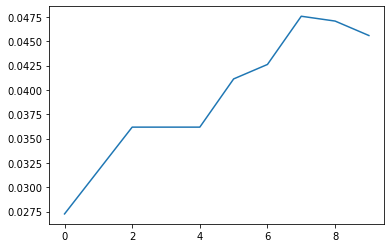

In [82]:
plt.plot(AllHitrate)   ###Max == 80

In [83]:
Vsvd_list = pureSVD(SVD_UserItemMAT,k=80)
print(len(Vsvd_list))

15


In [84]:
Vsvd_last = Vsvd_list[-1]
Vsvd_last

array([[ 4.34578900e-03,  4.93982809e-02, -2.88923818e-02, ...,
        -1.47644577e-02,  5.61380976e-02, -4.73890482e-02],
       [-8.42578970e-05,  4.94305880e-04,  2.46487147e-04, ...,
        -5.26775721e-03,  1.38938156e-02, -9.21305662e-03],
       [-8.28299990e-04,  4.23922733e-05, -5.14173537e-04, ...,
        -6.60214572e-05,  1.26832187e-04, -3.79104279e-04],
       ...,
       [-3.07402437e-05, -1.59730546e-05, -9.37798624e-06, ...,
         2.86918310e-06, -5.05549817e-06, -3.72356154e-06],
       [ 1.30471204e-05, -8.17110590e-06,  3.61482916e-05, ...,
        -4.57356329e-06,  1.80967438e-05, -1.75187204e-05],
       [-7.73844643e-05, -9.84212325e-05,  6.71522727e-05, ...,
         9.56328354e-06, -1.95749109e-05, -1.71249430e-05]])

### SVDAll Pred

In [85]:
AllUsersSVD_PRED =  TQDMgetALLTopNPred_ALLUSERS(SVD_UserItemMAT,Vsvd_list, N=10) 
print(len(AllUsersSVD_PRED))
AllUsersSVD_PRED[:2]

15it [02:24,  9.64s/it]15



[array([[ 1434,   145,   385, ...,   202,   687,  1386],
        [13773, 15563, 10498, ...,  9827,  5483, 11924],
        [  385,   145,     0, ...,   345,  7656,  1920],
        ...,
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317]]),
 array([[ 1434,   145,   385, ...,   202,   687,  1386],
        [13773, 11924, 12905, ...,  9827, 10498, 13576],
        [  385,   145,     0, ...,   345,  7656,  1920],
        ...,
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317]])]

In [88]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_SVD_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersSVD_PRED, f)


##  RandRec:Test

In [105]:
print(len(SVD_UserItemMAT),len(newHOLDOUT_LIST))

15 15


In [108]:
def TopN_RandomPred(RatingMat,user_column,N):  
    N_users,N_items = RatingMat.shape   
    PVVT_RandScores = np.random.rand(N_users,N_items)   ##Assigns random scores to items
    users_column = RatingMat.nonzero()[0]
    items_column = RatingMat.nonzero()[1]
    args = np.array([users_column,items_column])
    np.put(PVVT_RandScores, np.ravel_multi_index(args, PVVT_RandScores.shape),-np.inf)   ##downsample previously 
    TopN_pred = np.apply_along_axis(topN_Index, 1,PVVT_RandScores,n = N)
    return TopN_pred

def get_ALLRandPred(RatingMat_List,user_column,N):
    All_RandPred = []
    for RatingMat in tqdm(RatingMat_List):  
        Rand_pred =  TopN_RandomPred(RatingMat,user_column, N)
        All_RandPred.append(Rand_pred)
    return All_RandPred


In [109]:
All_UsersRRecPred = get_ALLRandPred(SVD_UserItemMAT,'Updated_UserID',N=10)
All_UsersRRecPred[:2]  

100%|██████████| 15/15 [03:41<00:00, 14.77s/it]


[array([[16141,  4418,  7208, ...,  7295,  5403,   160],
        [ 5495,  3308,  4251, ..., 14622,   255, 15757],
        [ 3467, 14436,  5882, ...,  4604, 11955,  4483],
        ...,
        [ 7599, 13798,  3161, ...,  6286,  7202,  4206],
        [14390, 10356,  9705, ...,  7564,  6148,  3613],
        [  800,  9473,  7287, ...,   676, 13600,  2410]]),
 array([[ 5494, 13631, 12490, ...,  1547,  5407,  9779],
        [ 6168,  3332,  6253, ...,  8446,  6486,  4044],
        [ 9052,  8182,  3624, ...,  6911,   230,  9858],
        ...,
        [10197,  4567, 10721, ...,  1221,  2147, 14997],
        [14447, 15975, 11750, ...,  9706,  5145, 14521],
        [12127,  1923,  7812, ..., 13509, 13081, 15564]])]

In [111]:
All_UsersRRecPred[2].shape

(39284, 10)

In [112]:
with open('AMZG_RRec_allPRED.pkl', 'wb') as f:
     pickle.dump(All_UsersRRecPred, f)


## Most Pop Rec

In [119]:
                      #getAll_MOSTPOP_Pred(DF_list,user_column,item_colum,Nusers,N
Nusers = newAMZGames_DF['Updated_UserID'].nunique()
All_MostPOPRED_List =  getAll_MOSTPOP_Pred(new_PSIDFlist,'Updated_UserID','Updated_ItemID',Nusers,N=10)
All_MostPOPRED_List[:2]

[array([[13858, 13252, 16038, ..., 16053, 15563, 15189],
        [13858, 13252, 16038, ..., 16053, 15563, 15189],
        [13858, 13252, 16038, ..., 16053, 15563, 15189],
        ...,
        [13858, 13252, 16038, ..., 16053, 15563, 15189],
        [13858, 13252, 16038, ..., 16053, 15563, 15189],
        [13858, 13252, 16038, ..., 16053, 15563, 15189]]),
 array([[13858, 16096, 16155, ..., 12073, 12586, 15685],
        [13858, 16096, 16155, ..., 12073, 12586, 15685],
        [13858, 16096, 16155, ..., 12073, 12586, 15685],
        ...,
        [13858, 16096, 16155, ..., 12073, 12586, 15685],
        [13858, 16096, 16155, ..., 12073, 12586, 15685],
        [13858, 16096, 16155, ..., 12073, 12586, 15685]])]

In [121]:
All_MostPOPRED_List[2].shape

(39284, 10)

In [122]:
with open('AMZG_MPOP_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_MostPOPRED_List, f)


## HitRate

### Updated PSI

In [89]:
V_1 = Vpsi_listUpdt[0]
V_1.shape

(16139, 80)

In [90]:
Top_NupdtPred = TopNPred(UserItem_Matupdt[0],newHOLDOUT_LIST[0],V_1,'Updated_UserID',10)
Top_NupdtPred

array([[ 5483,  2176,  1862, ...,  5549,  2154,  7253],
       [  138,  3753, 11370, ...,  3937,  2982, 12021],
       [ 8019,  5483, 11924, ...,  2176,  1862,   958],
       ...,
       [ 4109, 11918,  4110, ...,  7304,  4735,  8239],
       [ 9827,  7963, 12905, ...,  6103,  9254,  7656],
       [10377,  4109, 11924, ...,  6771, 13857, 11961]])

In [91]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top_NupdtPred,'Updated_UserID','Updated_ItemID')

Number of hits:  58
Total Num of users:  2018
Recommendation HitRate:  0.028741328047571853


0.028741328047571853

In [92]:
AllUpdt_pred =  TQDMgetALLTopNPred(UserItem_Matupdt,newHOLDOUT_LIST,Vpsi_listUpdt,'Updated_UserID',N = 10)
print(len(AllUpdt_pred))
AllUpdt_pred[:2]

15it [00:08,  1.75it/s]15



[array([[ 5483,  2176,  1862, ...,  5549,  2154,  7253],
        [  138,  3753, 11370, ...,  3937,  2982, 12021],
        [ 8019,  5483, 11924, ...,  2176,  1862,   958],
        ...,
        [ 4109, 11918,  4110, ...,  7304,  4735,  8239],
        [ 9827,  7963, 12905, ...,  6103,  9254,  7656],
        [10377,  4109, 11924, ...,  6771, 13857, 11961]]),
 array([[ 4735,   346,   687, ...,  6630,  1386,  7941],
        [ 7804,  6490,  4895, ...,  1805, 13857,  9917],
        [13778, 13703, 12073, ..., 11821,  7886, 14760],
        ...,
        [ 6103,  8220, 12021, ...,  9695,  7186,  4436],
        [10377, 10236, 11419, ...,  8892, 13857,  8766],
        [10377, 13857, 10362, ...,  5305, 13859, 11961]])]

In [93]:
AllSteps_HitR_updt, LowerBand_updt, Avg_HitR_updt, UpperBand_updt   = getAll_HitRate(newHOLDOUT_LIST,AllUpdt_pred,'Updated_UserID','Updated_ItemID')

Number of hits:  58
Total Num of users:  2018
Recommendation HitRate:  0.028741328047571853
Number of hits:  63
Total Num of users:  2200
Recommendation HitRate:  0.028636363636363637
Number of hits:  80
Total Num of users:  2172
Recommendation HitRate:  0.03683241252302026
Number of hits:  58
Total Num of users:  2079
Recommendation HitRate:  0.027898027898027897
Number of hits:  65
Total Num of users:  2089
Recommendation HitRate:  0.031115366203925323
Number of hits:  53
Total Num of users:  2120
Recommendation HitRate:  0.025
Number of hits:  45
Total Num of users:  2217
Recommendation HitRate:  0.02029769959404601
Number of hits:  44
Total Num of users:  2207
Recommendation HitRate:  0.01993656547349343
Number of hits:  52
Total Num of users:  2133
Recommendation HitRate:  0.02437880918893577
Number of hits:  51
Total Num of users:  2171
Recommendation HitRate:  0.02349147858129894
Number of hits:  43
Total Num of users:  2261
Recommendation HitRate:  0.01901813356921716
Number of

In [94]:
AllSteps_HitR_updt

[0.028741328047571853,
 0.028636363636363637,
 0.03683241252302026,
 0.027898027898027897,
 0.031115366203925323,
 0.025,
 0.02029769959404601,
 0.01993656547349343,
 0.02437880918893577,
 0.02349147858129894,
 0.01901813356921716,
 0.021816562778272486,
 0.0273224043715847,
 0.022036139268400177,
 0.009000900090009001]

### Regular PSI

In [95]:
Vpsi_listReg[0].shape

(17318, 80)

In [96]:
Top10Pred_psi = TopNPred(UserItemMAT_regPSI[0], newHOLDOUT_LIST[0],Vpsi_listReg[0],'Updated_UserID',N=10)
print(Top10Pred_psi.shape)

(2018, 10)


In [97]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_UserID','Updated_ItemID')

Number of hits:  61
Total Num of users:  2018
Recommendation HitRate:  0.03022794846382557


0.03022794846382557

In [98]:
All_regPSI_PRED =  TQDMgetALLTopNPred(UserItemMAT_regPSI,newHOLDOUT_LIST,Vpsi_listReg,'Updated_UserID',N = 10)
print(len(All_regPSI_PRED))
All_regPSI_PRED[:2]

15it [00:09,  1.65it/s]15



[array([[ 5483,  2176,  1862, ...,  5549,  2154,  7253],
        [  138,  3753, 11370, ..., 12021, 12905,  2982],
        [ 8019,  5483, 11924, ...,  2176,  1862,   958],
        ...,
        [ 4109, 11918,  4110, ...,  7304,  4735,  8239],
        [ 9827,  7963, 12905, ...,  6103,  9254, 12647],
        [10377,  4109, 11924, ..., 13857, 10236, 11961]]),
 array([[ 4735,   346,   687, ...,   825,  1386, 12055],
        [ 7804,  6490,  4895, ...,  6092,  9917, 13857],
        [13778, 13703, 12073, ...,  7886, 11821, 14760],
        ...,
        [ 6103,  8220, 12021, ...,  9695,  7186,  5950],
        [10377, 10236, 11419, ..., 10876,  8892,  8766],
        [10377, 13857, 10362, ...,  5305, 11972, 13646]])]

In [99]:
AllSteps_Hitrate_psi, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_UserID','Updated_ItemID')

Number of hits:  61
Total Num of users:  2018
Recommendation HitRate:  0.03022794846382557
Number of hits:  63
Total Num of users:  2200
Recommendation HitRate:  0.028636363636363637
Number of hits:  81
Total Num of users:  2172
Recommendation HitRate:  0.03729281767955801
Number of hits:  56
Total Num of users:  2079
Recommendation HitRate:  0.026936026936026935
Number of hits:  70
Total Num of users:  2089
Recommendation HitRate:  0.03350885591191958
Number of hits:  54
Total Num of users:  2120
Recommendation HitRate:  0.02547169811320755
Number of hits:  49
Total Num of users:  2217
Recommendation HitRate:  0.02210193955796121
Number of hits:  48
Total Num of users:  2207
Recommendation HitRate:  0.02174898051653829
Number of hits:  57
Total Num of users:  2133
Recommendation HitRate:  0.026722925457102673
Number of hits:  58
Total Num of users:  2171
Recommendation HitRate:  0.026715799170888992
Number of hits:  46
Total Num of users:  2261
Recommendation HitRate:  0.0203449800973

In [100]:
AllSteps_Hitrate_psi

[0.03022794846382557,
 0.028636363636363637,
 0.03729281767955801,
 0.026936026936026935,
 0.03350885591191958,
 0.02547169811320755,
 0.02210193955796121,
 0.02174898051653829,
 0.026722925457102673,
 0.026715799170888992,
 0.020344980097302078,
 0.024487978628673197,
 0.030054644808743168,
 0.024239753195240195,
 0.009450945094509451]

### SVD HItR_

In [101]:
print(Vsvd_list[0].shape)

(17318, 80)


In [102]:
Top10Pred_SVD = TopNPred(SVD_UserItemMAT[0],newHOLDOUT_LIST[0],Vsvd_list[0],'Updated_UserID',N=10)
print(Top10Pred_SVD.shape)
Top10Pred_SVD

(2018, 10)


array([[ 7529,  1862,  2176, ...,  4687,  9913,  4914],
       [ 2976,   138,  2136, ...,  3753,  2982,  3937],
       [ 7886,  9913, 13384, ..., 11414,  7926, 12055],
       ...,
       [ 4109,  9827, 11918, ..., 12027, 10236, 13862],
       [ 9827,  7963,  4436, ..., 13862, 14252,  6103],
       [10377,  4109,  4735, ...,  4110, 13858,  7886]])

In [103]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_UserID','Updated_ItemID')

Number of hits:  96
Total Num of users:  2018
Recommendation HitRate:  0.04757185332011893


0.04757185332011893

In [104]:
AllSVD_topNPRED =  TQDMgetALLTopNPred(SVD_UserItemMAT,newHOLDOUT_LIST,Vsvd_list,'Updated_UserID',N = 10)
print(len(AllSVD_topNPRED))
AllSVD_topNPRED[:2]

15it [00:09,  1.63it/s]15



[array([[ 7529,  1862,  2176, ...,  4687,  9913,  4914],
        [ 2976,   138,  2136, ...,  3753,  2982,  3937],
        [ 7886,  9913, 13384, ..., 11414,  7926, 12055],
        ...,
        [ 4109,  9827, 11918, ..., 12027, 10236, 13862],
        [ 9827,  7963,  4436, ..., 13862, 14252,  6103],
        [10377,  4109,  4735, ...,  4110, 13858,  7886]]),
 array([[ 4735,   346,  2232, ...,   385,  1050,   168],
        [ 7963,  6533,  4950, ...,  4919,  4895, 13825],
        [13778, 13703, 13831, ...,  4950, 13819, 12652],
        ...,
        [10247,  6103,  9566, ...,  1050, 10331,  9695],
        [13858, 14541, 15189, ..., 14390, 14604, 11114],
        [14541, 15189, 14801, ..., 14384, 14805, 14310]])]

In [105]:
AllSteps_Hitrate_svd, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHOLDOUT_LIST,AllSVD_topNPRED,'Updated_UserID','Updated_ItemID')

Number of hits:  96
Total Num of users:  2018
Recommendation HitRate:  0.04757185332011893
Number of hits:  99
Total Num of users:  2200
Recommendation HitRate:  0.045
Number of hits:  92
Total Num of users:  2172
Recommendation HitRate:  0.0423572744014733
Number of hits:  100
Total Num of users:  2079
Recommendation HitRate:  0.0481000481000481
Number of hits:  113
Total Num of users:  2089
Recommendation HitRate:  0.05409286740067018
Number of hits:  103
Total Num of users:  2120
Recommendation HitRate:  0.04858490566037736
Number of hits:  84
Total Num of users:  2217
Recommendation HitRate:  0.037889039242219216
Number of hits:  74
Total Num of users:  2207
Recommendation HitRate:  0.03352967829632986
Number of hits:  105
Total Num of users:  2133
Recommendation HitRate:  0.04922644163150492
Number of hits:  107
Total Num of users:  2171
Recommendation HitRate:  0.04928604329801935
Number of hits:  92
Total Num of users:  2261
Recommendation HitRate:  0.040689960194604156
Number o

In [106]:
AllSteps_Hitrate_svd

[0.04757185332011893,
 0.045,
 0.0423572744014733,
 0.0481000481000481,
 0.05409286740067018,
 0.04858490566037736,
 0.037889039242219216,
 0.03352967829632986,
 0.04922644163150492,
 0.04928604329801935,
 0.040689960194604156,
 0.04674977738201247,
 0.052823315118397086,
 0.05597179374173645,
 0.0288028802880288]

### RRec HitR_

In [141]:
RRec_AllStepsHitR, RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR = getAll_RandomHitRate(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')

Number of hits:  2
Total Num of users:  2018
Recommendation HitRate:  0.0009910802775024777
Number of hits:  3
Total Num of users:  2200
Recommendation HitRate:  0.0013636363636363637
Number of hits:  1
Total Num of users:  2172
Recommendation HitRate:  0.00046040515653775324
Number of hits:  2
Total Num of users:  2079
Recommendation HitRate:  0.000962000962000962
Number of hits:  0
Total Num of users:  2089
Recommendation HitRate:  0.0
Number of hits:  4
Total Num of users:  2120
Recommendation HitRate:  0.0018867924528301887
Number of hits:  3
Total Num of users:  2217
Recommendation HitRate:  0.0013531799729364006
Number of hits:  4
Total Num of users:  2207
Recommendation HitRate:  0.0018124150430448573
Number of hits:  2
Total Num of users:  2133
Recommendation HitRate:  0.0009376465072667605
Number of hits:  0
Total Num of users:  2171
Recommendation HitRate:  0.0
Number of hits:  1
Total Num of users:  2261
Recommendation HitRate:  0.0004422821760283061
Number of hits:  0
Total

### MPop HitR_

In [142]:
AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand  = getAll_MostPOPHitRate(newHOLDOUT_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')

Number of hits:  114
Total Num of users:  2018
Recommendation HitRate:  0.05649157581764123
Number of hits:  94
Total Num of users:  2200
Recommendation HitRate:  0.042727272727272725
Number of hits:  237
Total Num of users:  2172
Recommendation HitRate:  0.10911602209944751
Number of hits:  131
Total Num of users:  2079
Recommendation HitRate:  0.06301106301106302
Number of hits:  78
Total Num of users:  2089
Recommendation HitRate:  0.03733843944471039
Number of hits:  116
Total Num of users:  2120
Recommendation HitRate:  0.05471698113207547
Number of hits:  148
Total Num of users:  2217
Recommendation HitRate:  0.06675687866486242
Number of hits:  177
Total Num of users:  2207
Recommendation HitRate:  0.08019936565473493
Number of hits:  136
Total Num of users:  2133
Recommendation HitRate:  0.0637599624941397
Number of hits:  160
Total Num of users:  2171
Recommendation HitRate:  0.07369875633348687
Number of hits:  209
Total Num of users:  2261
Recommendation HitRate:  0.09243697

In [ ]:
##iALS

In [33]:
als_AllStepsHitR_, als_LBand, als_AvgHitR, als_UBand   = getAll_HitRate(newHOLDOUT_LIST,Allals_topNPRED,'Updated_UserID','Updated_ItemID')
als_AllStepsHitR_

Number of hits:  262
Total Num of users:  2018
Recommendation HitRate:  0.12983151635282458
Number of hits:  273
Total Num of users:  2200
Recommendation HitRate:  0.12409090909090909
Number of hits:  304
Total Num of users:  2172
Recommendation HitRate:  0.13996316758747698
Number of hits:  301
Total Num of users:  2079
Recommendation HitRate:  0.1447811447811448
Number of hits:  254
Total Num of users:  2089
Recommendation HitRate:  0.12158927716610819
Number of hits:  226
Total Num of users:  2120
Recommendation HitRate:  0.10660377358490566
Number of hits:  216
Total Num of users:  2217
Recommendation HitRate:  0.09742895805142084
Number of hits:  211
Total Num of users:  2207
Recommendation HitRate:  0.09560489352061623
Number of hits:  235
Total Num of users:  2133
Recommendation HitRate:  0.11017346460384435
Number of hits:  250
Total Num of users:  2171
Recommendation HitRate:  0.11515430677107324
Number of hits:  250
Total Num of users:  2261
Recommendation HitRate:  0.1105705

[0.12983151635282458,
 0.12409090909090909,
 0.13996316758747698,
 0.1447811447811448,
 0.12158927716610819,
 0.10660377358490566,
 0.09742895805142084,
 0.09560489352061623,
 0.11017346460384435,
 0.11515430677107324,
 0.11057054400707651,
 0.10685663401602849,
 0.1197632058287796,
 0.11811370647862494,
 0.0288028802880288]

In [34]:
print(als_LBand, als_AvgHitR, als_UBand)

0.09650553993232808 0.11128855880859082 0.12607157768485355


In [ ]:
##MRR Test

## MRR_Scores

### Updated_mrr

In [107]:
mrr_1st = MRR_Eval(newHOLDOUT_LIST[0],Top_NupdtPred,'Updated_ItemID')
print("1st Step MRR: ",mrr_1st)

1st Step MRR:  0.010185119637547785


In [108]:
AllSteps_MRRUpdt, LowerB_Updt, AvgMRR_Updt, UpperB_Updt  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllUpdt_pred,'Updated_ItemID')
AllSteps_MRRUpdt    

15it [00:00, 625.88it/s]


[0.010185,
 0.013654,
 0.01338,
 0.011199,
 0.011477,
 0.009797,
 0.007529,
 0.009307,
 0.009586,
 0.010436,
 0.007218,
 0.005953,
 0.010094,
 0.009585,
 0.002721]

In [109]:
print("Average MRR: ",AvgMRR_Updt)

Average MRR:  0.009475


### RegPSI_MRR

In [110]:
##MRR: 
mrr_psi_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_ItemID')
print("1st Step MRR: ",mrr_psi_1st)

1st Step MRR:  0.010435446064782042


In [111]:
psi_AllStepsMRR, psi_LowerB, psi_AvgMRR, psi_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_ItemID')
psi_AllStepsMRR  


15it [00:00, 634.58it/s]


[0.010435,
 0.01365,
 0.013784,
 0.01083,
 0.012396,
 0.009929,
 0.008309,
 0.008626,
 0.01006,
 0.011204,
 0.007652,
 0.006467,
 0.011027,
 0.009598,
 0.003073]

In [112]:
print("Average MRR: ",psi_AvgMRR)

Average MRR:  0.009803


### SVD_MRR

In [113]:
##MRR: 
mrr_SVD_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_ItemID')
print("1st Step MRR: ",mrr_SVD_1st)

1st Step MRR:  0.019357528277250773


In [115]:
svd_AllStepsMRR, svd_LowerB, svd_AvgMRR, svd_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllSVD_topNPRED,'Updated_ItemID')
svd_AllStepsMRR  


15it [00:00, 640.54it/s]


[0.019358,
 0.023652,
 0.020143,
 0.022079,
 0.025752,
 0.028113,
 0.021062,
 0.015026,
 0.019633,
 0.021855,
 0.019073,
 0.02022,
 0.022113,
 0.025357,
 0.012638]

In [116]:
svd_AvgMRR

0.021072

In [36]:
##mrr
als_AllStepsMRR, als_LBand, als_AvgMRR, als_UBand  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,Allals_topNPRED,'Updated_ItemID')
als_AllStepsMRR    

15it [00:00, 594.64it/s]


[0.049942,
 0.053576,
 0.054273,
 0.056051,
 0.059633,
 0.051975,
 0.04103,
 0.041182,
 0.049902,
 0.049107,
 0.048834,
 0.044036,
 0.050561,
 0.053631,
 0.01063]

In [37]:
print(als_LBand, als_AvgMRR, als_UBand)

0.041277 0.047624 0.053971


### RRec_MRR

In [156]:
RRec_AllStepsMRR, RRec_LowB, RRec_Avg_MRR, RRec_UppB = getAll_RandomRecMRR(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')
RRec_AllStepsMRR

15it [00:00, 299.83it/s]


[0.000578,
 0.000338,
 0.000153,
 0.000168,
 0,
 0.000218,
 0.000182,
 0.000374,
 0.000586,
 0,
 6.3e-05,
 0,
 0,
 0,
 0]

### Mpop_MRR

In [157]:
#MRR....
                                    #getAll_MostPOP_MRR(HOLDOUT_list,All_MostPOPRED_List,user_column,item_column)
Mpop_AllStepsMRR, Mpop_LowB, Mpop_AvgMRR, Mpop_UppB = getAll_MostPOP_MRR(newHOLDOUT_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')
Mpop_AllStepsMRR

15it [00:00, 199.08it/s]


[0.014842017084336212,
 0.01745256132756133,
 0.07358005203309072,
 0.04122842178397734,
 0.010668885393634076,
 0.013654162923030847,
 0.016223661318383917,
 0.03177893570961084,
 0.02674004122667976,
 0.040723315274213474,
 0.0550734328819247,
 0.01649369602397207,
 0.01795147020556857,
 0.030229735496372784,
 0.030533946251768036]

## Coverage

### UpdtedPSI_COV

In [117]:
StepCoverage_Ratio(newAMZGames_DF,AllUsers_updtPRED[0],'Updated_ItemID')

0.04556

In [118]:
UpdtAvg_Coverage_List = AllSteps_Coverage_Ratio(newAMZGames_DF,AllUsers_updtPRED,'Updated_ItemID')
UpdtAvg_Coverage_List

[0.04556,
 0.045444,
 0.045444,
 0.04556,
 0.045444,
 0.044809,
 0.045213,
 0.044693,
 0.044751,
 0.045271,
 0.044924,
 0.045675,
 0.045617,
 0.04556,
 0.045502]

###RegPSI_COV

In [119]:
psi_AvgCoverage_List = AllSteps_Coverage_Ratio(newAMZGames_DF,AllUsersRegPIS_PRED,'Updated_ItemID')
psi_AvgCoverage_List

[0.045502,
 0.045386,
 0.045213,
 0.045098,
 0.04504,
 0.045329,
 0.04504,
 0.045386,
 0.04504,
 0.045271,
 0.045329,
 0.045386,
 0.045502,
 0.045906,
 0.045733]

### SVD_COV


In [120]:
SVD_AvgCoverage_List = AllSteps_Coverage_Ratio(newAMZGames_DF,AllUsersSVD_PRED,'Updated_ItemID')
SVD_AvgCoverage_List

[0.04556,
 0.045791,
 0.04556,
 0.045213,
 0.045213,
 0.045386,
 0.045906,
 0.045906,
 0.046541,
 0.046368,
 0.046714,
 0.047061,
 0.046483,
 0.046426,
 0.045791]

In [38]:
###cOVERAGE:
als_AvgCovList = AllSteps_Coverage_Ratio(newAMZGames_DF,All_alsPRED_List,'Updated_ItemID')
als_AvgCovList

[0.067271,
 0.067271,
 0.067213,
 0.067156,
 0.067213,
 0.067156,
 0.067213,
 0.067213,
 0.067213,
 0.067213,
 0.067213,
 0.067156,
 0.067098,
 0.067098,
 0.067098]

### RRec_COV

In [164]:
##COVERAGE
RRec_AvgCoverageList = AllSteps_Coverage_Ratio(newAMZGames_DF,All_UsersRRecPred,'Updated_ItemID')
RRec_AvgCoverageList

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

### Mpop_COV

In [165]:
##COVERAGE
MPop_AvgCoverageList = AllSteps_Coverage_Ratio(newAMZGames_DF,All_MostPOPRED_List,'Updated_ItemID')
MPop_AvgCoverageList

[0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577]

In [ ]:
## AllSVD Prediction

## CORRELATION Report


In [42]:
##lOAD Saved Lists...
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_UpdtPSI_allPRED.pkl', 'rb') as f:
     AllUsers_updtPRED = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_PSI_allPRED.pkl', 'rb') as f:
     AllUsersRegPIS_PRED = pickle.load(f)


with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_SVD_allPRED.pkl', 'rb') as f:
     AllUsersSVD_PRED = pickle.load(f)

# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_SVD_allPRED.pkl', 'rb') as f:
#      AllUsersSVD_PRED = pickle.load(f)


with open('/home/oolaleke/incremental_PSI/Notebooks/AMZGms_iALS_allPRED.pkl', 'rb') as f:
     All_alsPRED_List = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_MPOP_AllPRED.pkl', 'rb') as f:
     All_MostPOPRED_List = pickle.load(f)


with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_RRec_allPRED.pkl', 'rb') as f:
     All_UsersRRecPred = pickle.load(f)     

#newAMZB_DF = pd.read_csv()

In [121]:
AllSteps = list(range(1,15))
print(len(AllSteps))
AllSteps

14


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

####  Updated_Corr 

In [ ]:
newUserItem_list

In [122]:
UpdtPSICorr_ = Updt_getAll_AvgCorr(AllUsers_updtPRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
UpdtPSICorr_

array([array([1., 1., 1., ..., 0., 0., 0.]),
       array([1.        , 0.94467132, 0.98788042, ..., 0.        , 0.        ,
              0.06033616])                                                    ,
       array([0.99244163, 1.        , 0.98788042, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([1.        , 1.        , 0.93397092, ..., 0.03534858, 0.        ,
              0.23873458])                                                    ,
       array([1.        , 1.        , 0.93397092, ..., 0.111429  , 0.10246453,
              0.01933435])                                                    ,
       array([1.        , 1.        , 0.93397092, ..., 0.33435777, 0.44061677,
              0.        ])                                                    ,
       array([0.99244163, 1.        , 0.93397092, ..., 0.        , 0.80884696,
              0.36155691])                                                    ,
 

In [123]:
UpdtPSICorr_.shape
for df in UpdtPSICorr_:
    print(df.mean())  

0.9680726500913674
0.9658616634107436
0.9653709211274857
0.9669961652095344
0.9687347193653832
0.9700946404946141
0.9676846471800108
0.9683982721467231
0.9675085247273923
0.9671354318497746
0.9713038895440378
0.9690137132374153
0.9676481949263103
0.9700115605981278


#### RegPSI Corr_

In [124]:
RegPSICorr_ = Updt_getAll_AvgCorr(AllUsersRegPIS_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
RegPSICorr_

array([array([1., 1., 1., ..., 0., 0., 0.]),
       array([1.        , 0.94467132, 0.93397092, ..., 0.        , 0.        ,
              0.06033616])                                                    ,
       array([0.98307362, 1.        , 0.96643133, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.02499653, 0.        ,
              0.35543109])                                                    ,
       array([1.        , 0.99244163, 1.        , ..., 0.11647255, 0.1053538 ,
              0.06677266])                                                    ,
       array([1.        , 0.92690249, 1.        , ..., 0.33014958, 0.44061677,
              0.        ])                                                    ,
       array([1.        , 0.98387314, 1.        , ..., 0.19996748, 0.7956453 ,
              0.36243655])                                                    ,
 

In [125]:
RegPSICorr_.shape
for df in RegPSICorr_:
    print(df.mean())  

0.9558582054356557
0.9541903421038225
0.9546681651980554
0.9550894634833644
0.9554055236251504
0.9562263009005716
0.9569987324766154
0.9587156851392303
0.9539716982301606
0.9568038105217984
0.9572353152364913
0.9585819520854937
0.9582293117301625
0.9619027185655068


#### SVD Corr_

In [126]:
pureSVDCorr_ = Updt_getAll_AvgCorr(AllUsersSVD_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
pureSVDCorr_

array([array([1.        , 0.54333508, 0.98387314, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0.9226361 , 0.81485124, 0.99244163, ..., 0.        , 0.        ,
              0.09331951])                                                    ,
       array([0.93321111, 0.75612658, 0.92690249, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0.78651821, 0.74512354, 0.84271627, ..., 0.        , 0.        ,
              0.12301255])                                                    ,
       array([0.92690249, 0.74656886, 0.9804132 , ..., 0.07736097, 0.08043621,
              0.19559407])                                                    ,
       array([1.        , 0.8998713 , 0.98788042, ..., 0.52942395, 0.50909834,
              0.        ])                                                    ,
       array([0.98788042, 0.83789841, 0.987880

In [127]:
pureSVDCorr_.shape
for df in pureSVDCorr_:
    print(df.mean())  

0.8037702425745978
0.8019338949532058
0.8066768773195171
0.7810016672182626
0.8436419351812148
0.8479125383243834
0.8678127646681513
0.8588567711323736
0.8346920757834289
0.8362061292212155
0.81594388599508
0.8177250888234795
0.8352680825555298
0.8366888881128417


In [50]:
##IALS..
iALSCorr_ = Updt_getAll_AvgCorr(All_alsPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
iALSCorr_

array([array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
              0.70836709])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 0.49096051,
              1.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.93397092, 1.        ,
              1.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.91813929, 1.        ,
              0.7956453 ])                                                    ,
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([1.        , 1.        , 1.        , ..., 0.93397092, 1.        ,
              1.        ])                                                    ,
       array([1.       , 1.       , 1.       , ..., 1.       , 0.7956453,
              1.       ])                                                ,
       arra

In [51]:
iALSCorr_.shape
for df in iALSCorr_:
    print(df.mean())  

0.9967433425370312
0.9967600091541361
0.9970130100414063
0.996871442732639
0.9966272694780534
0.9971921045976824
0.9974827954814323
0.9972900528644716
0.9970267746974989
0.9972094231037097
0.9970747919554998
0.9973786567199608
0.9970655078474026
0.9972261540505606


### RRec_Corr 

In [52]:
RandRec_Corr = Updt_getAll_AvgCorr(All_UsersRRecPred,newUserItem_list,AllSteps,'Updated_UserID')  #,
RandRec_Corr

array([array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [53]:
RandRec_Corr.shape
for df in RandRec_Corr:
    print(df.mean())  

0.00018938852830573005
0.00015479077771931346
0.00017015650373206369
0.00018682228286983054
0.00016458385548443193
0.0001866611350496244
0.00018824939177046766
0.0001701431999147521
0.00018879551616648419
0.0001567332310289805
0.00018423108944432665
0.00018467830958120293
0.00018689519887117728
0.0001719810808100546


### Mpop_Corr 

In [54]:
MPop_Corr = Updt_getAll_AvgCorr(All_MostPOPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
MPop_Corr



array([array([0.30787632, 0.30787632, 0.30787632, ..., 0.30787632, 0.30787632,
              0.30787632])                                                    ,
       array([0.09162168, 0.09162168, 0.09162168, ..., 0.09162168, 0.09162168,
              0.09162168])                                                    ,
       array([0.2828713, 0.2828713, 0.2828713, ..., 0.2828713, 0.2828713,
              0.2828713])                                                ,
       array([0.23335283, 0.23335283, 0.23335283, ..., 0.23335283, 0.23335283,
              0.23335283])                                                    ,
       array([0.27192831, 0.27192831, 0.27192831, ..., 0.27192831, 0.27192831,
              0.27192831])                                                    ,
       array([0.18780174, 0.18780174, 0.18780174, ..., 0.18780174, 0.18780174,
              0.18780174])                                                    ,
       array([0.29548047, 0.29548047, 0.29548047, ..., 0

In [55]:
MPop_Corr.shape
for df in MPop_Corr:
    print(df.mean())  

0.3078763178878355
0.0916216815795312
0.28287129573303205
0.2333528281393601
0.271928312941582
0.18780173801094296
0.2954804738920579
0.3272792663190075
0.2746740350574216
0.160717093882686
0.2700679686827842
0.13449123885644015
0.1835163954140944
0.123268908841881


## Multi VAE

In [283]:
from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat

In [284]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [290]:
class Encoder(nn.Module):
    def __init__(self, q_dims, dropout):  ## q_dims: List[int], dropout: List[float]
        super().__init__()

        self.q_dims = q_dims
        q_dims_ = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, q_dims_[:-1], q_dims_[1:])):
            self.q_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.q_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = F.normalize(X, p=2, dim=1)
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = torch.tanh(h)
            else:
                mu, logvar = torch.split(h, self.q_dims[-1], dim=1)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, p_dims, dropout):  #p_dims: List[int], dropout: List[float]
        super().__init__()

        self.p_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, p_dims[:-1], p_dims[1:])):
            self.p_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.p_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = X
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = torch.tanh(h)
        return h


class MultiVAE(nn.Module):
    def __init__(self,p_dims,q_dims,dropout_enc,dropout_dec): #p_dims:List[int],q_dims:List[int],dropout_enc:List[float],dropout_dec:List[float], 
        super().__init__()
        self.encode = Encoder(q_dims, dropout_enc)  #q_dims == Encoder dimensions
        self.decode = Decoder(p_dims, dropout_dec)  #p_dims == Decoder dimensions

    def forward(self, X):
        mu, logvar = self.encode(X)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        sampled_z = mu + float(self.training) * eps * std
        return self.decode(sampled_z), mu, logvar        

def vae_loss_fn(inp, out, mu, logvar, anneal):
    neg_ll = -torch.mean(torch.sum(F.log_softmax(out, 1) * inp, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return neg_ll + anneal * KLD


def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    # build the discount template
    tp = 1.0 / np.log2(np.arange(2, k + 2))
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[: min(n, k)]).sum() for n in heldout_batch.getnnz(axis=1)])
    return DCG[IDCG > 0.0] / IDCG[IDCG > 0.0]

#Recall = (Relevant_Items_Recommended in top-k)/(Relevant_Items)



In [286]:
def train_step(model, optimizer, data, epoch):
    model.train()
    running_loss = 0.0
    global update_count
    N = data.shape[0]
    idxlist = list(range(N))
    np.random.shuffle(idxlist)
    training_steps = len(range(0, N, batch_size))   #training_steps
    for batch_idx, start_idx in zip(range(training_steps), range(0, N, batch_size)):
        end_idx = min(start_idx + batch_size, N)
        X_inp = data[idxlist[start_idx:end_idx]]
        X_inp = torch.FloatTensor(X_inp.toarray()).to(device)
        if constant_anneal:
            anneal = anneal_cap
        else:
            anneal = min(anneal_cap, update_count / total_anneal_steps)
        update_count += 1
        optimizer.zero_grad()
        X_out, mu, logvar = model(X_inp)
        loss = vae_loss_fn(X_inp, X_out, mu, logvar, anneal)
        train_step.anneal = anneal
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        avg_loss = running_loss / (batch_idx + 1)
        #t.set_postfix(loss=avg_loss)


def eval_step(model,data_tr, data_te):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, r20_list, r50_list = [], [], []
    #with trange(eval_steps) as t:
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_te = data_te[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)

             X_out, mu, logvar = model(X_tr_inp)
             loss = vae_loss_fn(X_tr_inp, X_out, mu, logvar, train_step.anneal)
             running_loss += loss.item()
             avg_loss = running_loss / (batch_idx + 1)

             #Exclude examples from training set
             X_out = X_out.cpu().numpy()
             X_out[X_tr.nonzero()] = -np.inf

             n100 = NDCG_binary_at_k_batch(X_out, X_te, k=100)
             r50 = Recall_at_k_batch(X_out, X_te, k=50)
             #r20 = Recall_at_k_batch(X_out, X_te, k=20)

             r50_list.append(r50)
             n100_list.append(n100)
             #r20_list.append(r20)
                

    n100_list = np.concatenate(n100_list)
    r50_list = np.concatenate(r50_list)
    #r20_list = np.concatenate(r20_list)
    return avg_loss, np.mean(n100_list), np.mean(r50_list) 

In [261]:
def getTot_annealSTeps(train_RatMat,batch_size,n_epochs,anneal_cap):
    training_steps = len(range(0, train_RatMat.shape[0], batch_size))
    try:
       total_anneal_steps = (training_steps * (n_epochs - int(n_epochs * 0.2))) / anneal_cap  ##
    except ZeroDivisionError:
        assert (constant_anneal), "if 'anneal_cap' is set to 0.0 'constant_anneal' must be set to 'True"

    return total_anneal_steps

#############################################
def early_stop(curr_value, best_value, stop_step, patience, score_fn='metric'):
    if (score_fn == "loss" and curr_value <= best_value) or (score_fn == "metric" and curr_value >= best_value):
        stop_step, best_value = 0, curr_value
    else:
        stop_step += 1
    if stop_step >= patience:
        print("Early stopping triggered. patience: {} log:{}".format(patience, best_value))
        stop = True
    else:
        stop = False
    return best_value, stop_step, stop 

def init_weights(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            nn.init.xavier_uniform_(param.data)
        elif "bias" in name:
            param.data.normal_(std=0.001)
  


In [262]:
def get_holdoutRatMat(Holdout_MATList,newHoldout_list):
    HOLDOUT_MATList = []
    for holdoutMAT, holdout_df in zip(Holdout_MATList,newHoldout_list):
        heldout_users = holdout_df['Updated_UserID']
        Holdout_Mat = holdoutMAT[heldout_users,:] 
        HOLDOUT_MATList.append(Holdout_Mat)
    return  HOLDOUT_MATList

 

In [313]:
##lOAD Saved Lists...
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_newUserItem.pkl', 'rb') as f:   #
     newUserItem_list = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_newPSITest.pkl', 'rb') as f:
     newPSIDF_LIST = pickle.load(f)


with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_newHoldout.pkl', 'rb') as f:
     newHOLDOUT_LIST = pickle.load(f)


In [314]:
newAMZGames_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_afterUpdt.csv')

print(newAMZGames_DF.shape)   #userId_int
print(newAMZGames_DF.dtypes)
newAMZGames_DF.head()

(345203, 9)
userid            object
ProductID         object
rating             int64
timestamp         object
timestamp_YM      object
userId             int64
productId          int64
Updated_UserID     int64
Updated_ItemID     int64
dtype: object


,userid,ProductID,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
0,A2AXQTB83VMK4L,B0000296O5,1,1999-10-14,1999-10,0,0,0,0
1,A2T04VAIXSKJH2,B00002NDRY,1,1999-11-05,1999-11,1,1,1,1
2,A1QA8K3LD9K892,B000021Y5F,1,1999-11-10,1999-11,2,2,2,2
3,A1QA8K3LD9K892,B000021Y5Q,1,1999-11-10,1999-11,2,3,2,3
4,ANLA598UNJI8A,B00001IVGE,1,1999-11-14,1999-11,3,4,3,4


In [25]:
print(newAMZGames_DF['Updated_UserID'].nunique())
print(newAMZGames_DF['Updated_ItemID'].nunique())

39284
17318


In [322]:
newUserItem_list[0]['Updated_UserID'].nunique()

34571

In [317]:
len(newHOLDOUT_LIST[0]['Updated_UserID'])

2018

In [128]:
# rows_i = newAMZGames_DF['Updated_UserID'].nunique()
# cols_i = newAMZGames_DF['Updated_ItemID'].nunique()
# UserItem_MATList = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
# print(len(UserItem_MATList))   
# UserItem_MATList

In [320]:
UserItem_df1 =  newUserItem_list[0]
trainusers_ = UserItem_df1['Updated_UserID'].unique()
testusers = newHOLDOUT_LIST[0]['Updated_UserID'].unique()
print(len(testusers))
print(len(trainusers_))

true_trUsers = np.setdiff1d(trainusers_,testusers)  #elements in 'trainusers_' not in 'testusers' == new_items
print(len(true_trUsers))
true_trUsers

2018
34571
32558


array([    0,     1,     2, ..., 34489, 34494, 34570])

In [223]:
# UserItem_df1 =  newUserItem_list[0]
# trainItems_ = UserItem_df1['Updated_ItemID'].unique()
# print(len(trainItems_))
# #print(sorted(trainusers_)[200:300])
# trainItems_

#  testItems = newHOLDOUT_LIST[0]['Updated_ItemID'].unique()
#  print(len(testItems))
#  #print(sorted(testusers)[:100])
#  testItems

#  true_trItems = np.setdiff1d(trainItems_,testItems)  #elements in 'trainusers_' not in 'testusers' == new_items
# print(len(true_trItems))
# true_trItems

In [302]:
def topN_Index(a, n):
    parted = np.argpartition(a, -n)[-n:]
    return parted[np.argsort(-a[parted])]  


def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):  #Hello2021
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    # build the discount template
    tp = 1.0 / np.log2(np.arange(2, k + 2))
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[: min(n, k)]).sum() for n in heldout_batch.getnnz(axis=1)])
    return DCG[IDCG > 0.0] / IDCG[IDCG > 0.0]


def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(np.float32)
    denominator = np.minimum(k, X_true_binary.sum(axis=1))
    recall = tmp[denominator > 0.0] / denominator[denominator > 0.0]
    return recall

def HR_at_k_batch(pred_scores, ground_truth, k=10):  #"pred_scores' and 'ground_truth' must have the same shape."
    k = min(pred_scores.shape[1], k)
    idx = bn.argpartition(-pred_scores, k-1, axis=1)
    pred_scores_binary = np.zeros_like(pred_scores, dtype=bool)
    pred_scores_binary[np.arange(pred_scores.shape[0])[:, np.newaxis], idx[:, :k]] = True
    X_true_binary = (ground_truth > 0)
    num = (np.logical_and(X_true_binary, pred_scores_binary).sum(axis=1)).astype(np.float32)
    return num > 0
   
def MRR_at_k_batch(pred_scores, ground_truth, k=10):  #'pred_scores' and 'ground_truth' must have the same shape
       #Compute the Mean Reciprocal Rank (MRR)             
    k = min(pred_scores.shape[1], k)
    idx = np.argsort(-pred_scores)
    hits = ground_truth[np.arange(ground_truth.shape[0])[:, np.newaxis], idx[:, :k]]
    rranks, cranks = hits.nonzero()

    mrr = [0. for _ in range(ground_truth.shape[0])]
    for i, r in enumerate(rranks):
        if mrr[r] == 0:
           mrr[r] = 1. / (1 + cranks[i])

    return np.array(mrr)


In [323]:
trUserItem_df1 = UserItem_df1[ UserItem_df1['Updated_UserID'].isin(true_trUsers)]  #UserItem_df1['Updated_UserID'].isin(true_trUsers)& 
trUserItem_df1['Updated_UserID'].nunique()

32558

In [425]:
# Save index dictionaries to "numerise" later one
trainItems_ = trUserItem_df1['Updated_ItemID'].unique()
unique_uid =  newAMZGames_DF['Updated_UserID'].unique()
item2id = dict((sid, i) for (i, sid) in enumerate(trainItems_))
user2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))
print(len(item2id))
print(len(user2id))

15993
39284


In [418]:
rows_i = trUserItem_df1['Updated_UserID'].max()+1
cols_i = trUserItem_df1['Updated_ItemID'].max()+1
#UserItem_MAT_1 = SingleRatingMatrix( newUserItem_list[0],'Updated_UserID','Updated_ItemID',rows_i,cols_i)
UserItem_MAT_1 = SingleRatingMatrix(trUserItem_df1,'Updated_UserID','Updated_ItemID',rows_i,cols_i)
UserItem_MAT_1    

<34571x16120 sparse matrix of type '<class 'numpy.float64'>'
	with 233619 stored elements in Compressed Sparse Row format>

In [427]:
valid_df = newHOLDOUT_LIST[0]
valid_df = valid_df[valid_df['Updated_ItemID'].isin(trainItems_)]
#print(newHOLDOUT_LIST[0]['Updated_ItemID'].nunique())
valid_df['Updated_UserID'].nunique()

1891

In [428]:
Train_DF   =    numerize_data(trUserItem_df1,user2id,item2id, 'Updated_UserID','Updated_ItemID')
Valid_DF   = numerize_data(valid_df,user2id,item2id,'Updated_UserID','Updated_ItemID')

In [432]:
n_items = len(trainItems_)
TrainDF_RatMat = get_TrainRatMat(Train_DF,'Updated_UserID','Updated_ItemID',n_items)
TrainDF_RatMat

<34699x15993 sparse matrix of type '<class 'numpy.float64'>'
	with 233619 stored elements in Compressed Sparse Row format>

In [433]:
Valid_DFRatMat = get_TrainRatMat(Valid_DF,'Updated_UserID','Updated_ItemID',n_items)
Valid_DFRatMat

<34705x15993 sparse matrix of type '<class 'numpy.float64'>'
	with 1891 stored elements in Compressed Sparse Row format>

In [435]:
heldout_users = Valid_DF['Updated_UserID']
Holdout_Mat = Valid_DFRatMat[heldout_users,:] 
#holdoutMAT_1 
Holdout_Mat

<1891x15993 sparse matrix of type '<class 'numpy.float64'>'
	with 1891 stored elements in Compressed Sparse Row format>

In [417]:
# valid_df = newHOLDOUT_LIST[0]
# holdoutMAT_1 = SingleRatingMatrix(valid_df,'Updated_UserID','Updated_ItemID',rows_i,cols_i)
# heldout_users = Valid_DF['Updated_UserID']
# Holdout_Mat = Valid_DFRatMat[heldout_users,:] 
# #holdoutMAT_1 
# Holdout_Mat

<2018x17318 sparse matrix of type '<class 'numpy.float64'>'
	with 2018 stored elements in Compressed Sparse Row format>

In [132]:

# def getPred_(model,data_tr,batch_size,k=10):
#     model.eval()
#     running_loss = 0.0
#     eval_idxlist = list(range(data_tr.shape[0]))
#     eval_N = data_tr.shape[0]
#     eval_steps = len(range(0, eval_N, batch_size))
#     n100_list, hr10_list, mrr10_list = [], [], []
#     users_pred = []
#     with torch.no_grad():
#          for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
#              end_idx = min(start_idx + batch_size, eval_N)
#              X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
#              X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
#              #Make pred:    
#              X_out, mu, logvar = model(X_tr_inp)
#              X_out = X_out.cpu().numpy()        #X_out[X_tr.nonzero()] = -np.inf
#              topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = 10) 
#              #batch_users = X_out.shape[0]
#              #idx_topk_part = bn.argpartition(-X_out, k, axis=1)##Not this
#              #topk_part = X_out[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]  
#              #idx_part = np.argsort(-topk_part, axis=1)   ##Not this
#              #idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]      
#              users_pred.append(topN_pred)
        
#          AllUserPRED = np.vstack(users_pred)
#     return AllUserPRED 

def eval_step(model,data_tr,data_te):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n10_list, hr10_list,mrr10_list = [], [], []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_te = data_te[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)

             X_out, mu, logvar = model(X_tr_inp)
             #loss = vae_loss_fn(X_tr_inp, X_out, mu, logvar, train_step.anneal)
             #running_loss += loss.item()
             #avg_loss = running_loss / (batch_idx + 1)

             #Exclude examples from training set
             X_out = X_out.cpu().numpy()
             #X_out[X_tr.nonzero()] = -np.inf
             X_pred =  X_out[heldout_users,:]     
             n10 = NDCG_binary_at_k_batch(X_pred, X_te, k=10)
             #r10 = Recall_at_k_batch(X_out, X_te, k=10)
             hr10 =  HR_at_k_batch(X_out, X_te.toarray(), k=10)   # #X_tr.toarray() == groundTruth
             mrr10 = MRR_at_k_batch(X_out, X_te.toarray(), k=10)

             
             #r10_list.append(r10)
             n10_list.append(n10)
             hr10_list.append(hr10)
             mrr10_list.append(mrr10)
                
    n10_list = np.concatenate(n10_list)
    #r10_list = np.concatenate(r10_list)
    hr10_list = np.concatenate(hr10_list)
    mrr10_list = np.concatenate(mrr10_list)
    return np.mean(n10_list) ,np.mean(hr10_list),np.mean(mrr10_list)



In [409]:
def topN_Index(a, n):
    parted = np.argpartition(a, -n)[-n:]
    return parted[np.argsort(-a[parted])]  

def getall_UsersPred(model,data_tr,batch_size,k=10):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list = [], [], []
    users_pred = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()        
             topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = 10)     
             users_pred.append(topN_pred)        
         AllUserPRED = np.vstack(users_pred)
         
    return AllUserPRED 
 

def get_evalMetrics(model,data_tr):
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    hr10_list, mrr10_list = [], []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()     
             #n100 =  NDCG_binary_at_k_batch(X_out, X_tr, k=100)
             hr10 =  HR_at_k_batch(X_out, X_tr.toarray(), k=10)   # #X_tr.toarray() == groundTruth
             mrr10 = MRR_at_k_batch(X_out, X_tr.toarray(), k=10)

             #n100_list.append(n100)   
             hr10_list.append(hr10)
             mrr10_list.append(mrr10)
                
    #n100_list = np.concatenate(n100_list)
    hr10_list = np.concatenate(hr10_list)
    mrr10_list = np.concatenate(mrr10_list)
    return np.mean(hr10_list), np.mean(mrr10_list)

   #getmetrics_(model_,holdout_Mat,holdout_df,batch_size=holdout_Mat.shape[0],k)
def getmetrics_(model,data_tr,holdout_df,batch_size,k=10):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list = [], [], []
    users_pred = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()        
             #topN_pred = TopNPred(holdout_df,X_out,k)
             topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = k)     
             users_pred.append(topN_pred)        
         AllUserPRED = np.vstack(users_pred)
    hr_value = Hitrate_Eval(holdout_df,AllUserPRED,'Updated_UserID','Updated_ItemID')   
    mrr_value = MRR_Eval(holdout_df,AllUserPRED,'Updated_ItemID') 
    return hr_value,mrr_value     

def singlestep_predEval(model_,UserItemMat,holdout_Mat,holdout_df,pred_BS,n_epoch,k=10):
    for epoch in range(n_epoch):
        train_step(model_, optimizer, UserItemMat, epoch)
    
    hr10,mrr10 = getmetrics_(model_,holdout_Mat,holdout_df,holdout_Mat.shape[0],k)
    allUserPRED = getall_UsersPred(model_,UserItemMat,pred_BS,k)
    return  hr10,mrr10,allUserPRED

def Allsteps_predEval(model_,UserItemMatList,holdout_MatList,newHoldoutList, pred_BS,n_epoch,k=10):   
    hr10_List = [] 
    mrr10_List = [] 
    ALLUsers_Pred = []
    for UserItemMat,holdout_Mat,holdout_df in tqdm(zip(UserItemMatList,holdout_MatList,newHoldoutList)):
        hr10,mrr10,allUserpred_ = singlestep_predEval(model_,UserItemMat,holdout_Mat,holdout_df,pred_BS,n_epoch,k)
        hr10_List.append(hr10)   
        mrr10_List.append(mrr10)
        ALLUsers_Pred.append(allUserpred_)
        print("| HitRate  {:4.3f} | Mrr {:4.3f} | ".format(hr10, mrr10))
    return hr10_List,mrr10_List ,ALLUsers_Pred    

In [437]:
#I =  UserItem_MAT_1.shape[1]  #I is the total number of items in the train date
I  = len(trainItems_)
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)


init_weights(VAEmodel)
VAEmodel.to(device)
optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel              

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=15993, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=15993, bias=True)
    )
  )
)

device(type='cuda')

In [438]:
batch_size = 500
anneal_cap = 0.2
update_count = 0
n_epochs = 100
constant_anneal = False

In [440]:
 total_anneal_steps = getTot_annealSTeps(TrainDF_RatMat,batch_size,n_epochs,anneal_cap)
 total_anneal_steps

28000.0

In [441]:
total_anneal_steps = 28000 ##..

In [442]:
TrainDF_RatMat

<34699x15993 sparse matrix of type '<class 'numpy.float64'>'
	with 233619 stored elements in Compressed Sparse Row format>

In [443]:
for epoch in tqdm(range(100)):
    train_step(VAEmodel, optimizer, TrainDF_RatMat, epoch)


100%|██████████| 100/100 [03:58<00:00,  2.39s/it]


In [475]:
def getmetrics_(model,data_tr,holdout_df,batch_size,k=10):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list = [], [], []
    users_pred = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()  
             #X_out[X_tr.nonzero()] = -np.inf      
             topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = k)     
             users_pred.append(topN_pred)        
         AllUserPRED = np.vstack(users_pred)
    hr_value = Hitrate_Eval(holdout_df,AllUserPRED,'Updated_UserID','Updated_ItemID')   
    mrr_value = MRR_Eval(holdout_df,AllUserPRED,'Updated_ItemID') 
    return hr_value,mrr_value  

In [480]:
#Holdout_Mat  
# holdoutMAT_1
# heldout_users = valid_df['Updated_UserID']
# Holdout_Mat =  holdoutMAT_1[heldout_users,:] 
# holdoutMAT_1 

heldout_users = Valid_DF['Updated_UserID']
Holdout_Mat = Valid_DFRatMat[heldout_users,:] 
Holdout_Mat

<1891x15993 sparse matrix of type '<class 'numpy.float64'>'
	with 1891 stored elements in Compressed Sparse Row format>

In [481]:
getmetrics_(VAEmodel,Holdout_Mat,Valid_DF,batch_size=500,k=10)

Number of hits:  1784
Total Num of users:  1891
Recommendation HitRate:  0.9434161819143311


(0.9434161819143311, 0.9179543031737637)

In [403]:
def get_evalMetrics(model,data_tr):
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    hr10_list, mrr10_list = [], []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()    
             #X_out[heldout_users,:]  
             #n100 =  NDCG_binary_at_k_batch(X_out, X_tr, k=100)
             hr10 =  HR_at_k_batch(X_out, X_tr.toarray(), k=10)   # #X_tr.toarray() == groundTruth
             mrr10 = MRR_at_k_batch(X_out, X_tr.toarray(), k=10)

             #n100_list.append(n100)   
             hr10_list.append(hr10)
             mrr10_list.append(mrr10)
                
    #n100_list = np.concatenate(n100_list)
    hr10_list = np.concatenate(hr10_list)
    mrr10_list = np.concatenate(mrr10_list)
    return hr10_list,mrr10_list #np.mean(hr10_list), np.mean(mrr10_list)


In [471]:
# def get_evalMetrics(model,data_tr):
#     eval_idxlist = list(range(data_tr.shape[0]))
#     eval_N = data_tr.shape[0]
#     eval_steps = len(range(0, eval_N, batch_size))
#     hr10_list, mrr10_list,all_Xout = [], [],[]
#     with torch.no_grad():
#          for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
#              end_idx = min(start_idx + batch_size, eval_N)
#              X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
#              X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
#              #Make pred:    
#              X_out, mu, logvar = model(X_tr_inp)
#              X_out = X_out.cpu().numpy() 
#              all_Xout.append(X_out)
#     all_Xout = np.concatenate(all_Xout)         
#     return all_Xout

In [ ]:
all_Xout

In [482]:
Valid_DFRatMat

<34705x15993 sparse matrix of type '<class 'numpy.float64'>'
	with 1891 stored elements in Compressed Sparse Row format>

In [445]:
Holdout_Mat

<1891x15993 sparse matrix of type '<class 'numpy.float64'>'
	with 1891 stored elements in Compressed Sparse Row format>

In [ ]:
eval_step(VAEmodel,Valid_DFRatMat) ##...

In [452]:
# holdoutMAT_1   eval_step(VAEmodel,Valid_DFRatMat) ##...

In [472]:
all_Xout = get_evalMetrics(VAEmodel,Valid_DFRatMat)
print(all_Xout.shape)
all_Xout

(34705, 15993)


array([[ 2.4424322 ,  0.31981206, -3.075183  , ..., -6.2124057 ,
        -5.643233  , -8.394986  ],
       [ 2.4424322 ,  0.31981206, -3.075183  , ..., -6.2124057 ,
        -5.643233  , -8.394986  ],
       [ 2.4424322 ,  0.31981206, -3.075183  , ..., -6.2124057 ,
        -5.643233  , -8.394986  ],
       ...,
       [ 2.4424329 ,  0.3198122 , -3.0751822 , ..., -6.2124043 ,
        -5.643234  , -8.394986  ],
       [ 2.7001956 ,  0.4640211 , -4.7893987 , ..., -3.81392   ,
        -3.5630395 , -6.860027  ],
       [ 3.6731014 , -1.349139  , -0.26375774, ..., -5.8695393 ,
        -5.6106277 , -8.747262  ]], dtype=float32)

In [ ]:
heldout_users = Valid_DF['Updated_UserID']
Holdout_Mat = Valid_DFRatMat[heldout_users,:] 
#holdoutMAT_1 
Holdout_Mat

In [473]:
holdout_pred = all_Xout[heldout_users,:]
print(holdout_pred.shape)
holdout_pred

(1891, 15993)


array([[ 1.533822  ,  3.2953055 , -4.3575788 , ..., -8.938703  ,
        -8.5877    , -5.6790233 ],
       [ 2.5483587 ,  2.123441  , -1.8649957 , ..., -5.696309  ,
        -5.64353   , -7.2749705 ],
       [ 2.046613  , -3.2168002 , -2.6525056 , ..., -5.400098  ,
        -5.675798  , -9.792383  ],
       ...,
       [-1.0551393 , -0.573854  , -3.942324  , ..., -3.130574  ,
        -2.2338066 , -6.0773206 ],
       [ 2.7001956 ,  0.4640211 , -4.7893987 , ..., -3.81392   ,
        -3.5630395 , -6.860027  ],
       [ 3.6731014 , -1.349139  , -0.26375774, ..., -5.8695393 ,
        -5.6106277 , -8.747262  ]], dtype=float32)

In [469]:
# topN_pred = TopNPred(Holdout_Mat,holdout_pred, N=10)
# topN_pred

In [474]:
Hitrate_Eval(Valid_DF,holdout_pred,'Updated_UserID','Updated_ItemID') 
hr_value = Hitrate_Eval(holdout_df,holdout_pred,'Updated_UserID','Updated_ItemID')   
mrr_value = MRR_Eval(holdout_df,holdout_pred,'Updated_ItemID')     

Number of hits:  0
Total Num of users:  1891
Recommendation HitRate:  0.0


NameError: name 'holdout_df' is not defined

In [483]:
eval_step(VAEmodel,Valid_DFRatMat) ##...

(0.9239869823617919, 0.05140469672957787, 0.05001733431210451)

In [459]:
Valid_DFRatMat

<34705x15993 sparse matrix of type '<class 'numpy.float64'>'
	with 1891 stored elements in Compressed Sparse Row format>

In [404]:
#get_eval(model,data_tr):
hr, mrr = get_evalMetrics(VAEmodel,holdoutMAT_1)

In [408]:
len(hr[hr>0])

1950

In [410]:
len(mrr[mrr>0])

1950

In [375]:
#Holdout_Mat  
holdoutMAT_1
heldout_users = valid_df['Updated_UserID']
Holdout_Mat = holdoutMAT_1[heldout_users,:] 
Holdout_Mat 

<2018x17318 sparse matrix of type '<class 'numpy.float64'>'
	with 2018 stored elements in Compressed Sparse Row format>

In [376]:
 eval_step(VAEmodel,Holdout_Mat)

(0.8637661389786107, 0.8810703666997026, 0.8580379756792046)

In [361]:
#get_eval(model,data_tr):
get_eval(VAEmodel,Holdout_Mat)

(0.9265440233787886, 0.9402432575356954, 0.9156640057750582)

In [57]:
                                      #Allsteps_predEval(model_,UserItemMatList,holdout_MatList,newHoldoutList, pred_BS,n_epoch,k=10)
hr10_List,mrr10_List ,ALLUsersPred_ = Allsteps_predEval(VAEmodel,UserItem_MATList,HOLDOUT_MATList,newHOLDOUT_LIST,pred_BS=500,n_epoch=50,k=10)

0it [00:00, ?it/s]Number of hits:  1939
Total Num of users:  2018
Recommendation HitRate:  0.9608523290386521
1it [02:39, 159.61s/it]| HitRate  0.961 | Mrr 0.948 | 
Number of hits:  2085
Total Num of users:  2200
Recommendation HitRate:  0.9477272727272728
2it [05:18, 159.38s/it]| HitRate  0.948 | Mrr 0.931 | 
Number of hits:  2105
Total Num of users:  2172
Recommendation HitRate:  0.9691528545119705
3it [07:59, 159.75s/it]| HitRate  0.969 | Mrr 0.949 | 
Number of hits:  1942
Total Num of users:  2079
Recommendation HitRate:  0.9341029341029341
4it [10:41, 160.71s/it]| HitRate  0.934 | Mrr 0.918 | 
Number of hits:  2006
Total Num of users:  2089
Recommendation HitRate:  0.9602680708472954
5it [13:21, 160.46s/it]| HitRate  0.960 | Mrr 0.936 | 
Number of hits:  2031
Total Num of users:  2120
Recommendation HitRate:  0.9580188679245283
6it [16:02, 160.60s/it]| HitRate  0.958 | Mrr 0.933 | 
Number of hits:  2124
Total Num of users:  2217
Recommendation HitRate:  0.9580514208389715
7it [18:

In [58]:
hr10_List

[0.9608523290386521,
 0.9477272727272728,
 0.9691528545119705,
 0.9341029341029341,
 0.9602680708472954,
 0.9580188679245283,
 0.9580514208389715,
 0.9546896239238786,
 0.976558837318331,
 0.9719023491478581,
 0.9615214506855374,
 0.9893143365983972,
 0.9849726775956285,
 0.9867783164389599,
 0.9675967596759676]

In [59]:
mrr10_List

[0.947739589724228,
 0.9307260101010101,
 0.9490656698529627,
 0.9181421165548149,
 0.9362085603349367,
 0.9329692647499253,
 0.925334357167916,
 0.9316564898123575,
 0.9517180883917875,
 0.9375664422071609,
 0.9454504608861087,
 0.9653466833453476,
 0.9574939644953306,
 0.966598459568931,
 0.948531103110311]

In [60]:
ALLUsersPred_[:2]

[array([[ 1531,   144,    39, ...,   710,   825,   204],
        [ 9647, 13779,     7, ..., 12348,  2687,     1],
        [    3,     2,  4788, ...,    19,   124,  2127],
        ...,
        [12918, 10874, 13171, ...,  9913, 13491,  7304],
        [12918, 10874, 13171, ...,  9913, 13491,  7304],
        [12918, 10874, 13171, ...,  9913, 13491,  7304]]),
 array([[   39,  1531,   958, ...,  1991,   235,   243],
        [    7,     1, 13779, ..., 11230,  3367,  2664],
        [  564,   384,   390, ...,   284,    19,  4788],
        ...,
        [12918, 10874, 12043, ..., 13491,  9913, 13384],
        [12918, 10874, 12043, ..., 13491,  9913, 13384],
        [12918, 10874, 12043, ..., 13491,  9913, 13384]])]

In [65]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZB_VAE_allPRED_NEW.pkl', 'wb') as f:   #/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles
     pickle.dump(ALLUsersPred_, f)  

In [61]:
VAE_CovList = AllSteps_Coverage_Ratio(newAMZGames_DF,ALLUsersPred_,'Updated_ItemID')
VAE_CovList 

[0.924241,
 0.932498,
 0.940582,
 0.946818,
 0.954036,
 0.961832,
 0.969396,
 0.97621,
 0.97979,
 0.983023,
 0.983947,
 0.987758,
 0.98822,
 0.991108,
 0.993764]

In [62]:
AllSteps = list(range(1,15))
print(len(AllSteps))   #Hello2021
AllSteps 

14


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [63]:
VAECorr_ = Updt_getAll_AvgCorr(ALLUsersPred_,newUserItem_list,AllSteps,'Updated_UserID')  #,
VAECorr_

array([array([0.35232686, 0.27390404, 0.28275982, ..., 0.07657526, 0.        ,
              0.02180383])                                                    ,
       array([0.48049343, 0.59883028, 0.35667678, ..., 0.        , 0.03534858,
              0.        ])                                                    ,
       array([0.75759019, 0.69056344, 0.34628363, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0.34973027, 0.56925694, 0.33604851, ..., 0.07165154, 0.04457968,
              0.10213528])                                                    ,
       array([0.79870842, 0.65995727, 0.35319461, ..., 0.04325088, 0.        ,
              0.05873915])                                                    ,
       array([0.85662181, 0.48780488, 0.38884185, ..., 0.03534858, 0.06033616,
              0.        ])                                                    ,
       array([0.59176192, 0.4357129 , 0.361933

In [64]:
print(VAECorr_.shape)
for df in VAECorr_:
    print(df.mean())    


(14,)
0.5111650831111791
0.5247335389890364
0.5306557581310182
0.5339006599565076
0.5341660126327813
0.5390096999887687
0.5409274330342736
0.5420277971886575
0.543709788106349
0.546247757070087
0.5476100738669618
0.5490711755628648
0.5509607153132491
0.549736140618877


In [23]:
raw_data = newAMZGames_DF
user_activity =   raw_data['Updated_UserID'].unique()
item_popularity = raw_data['Updated_ItemID'].unique()
print(user_activity.shape)
print(item_popularity.shape)
print()
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

(39284,)
(17318,)

After filtering, there are 345203 watching events from 39284 users and 17318 movies (sparsity: 0.051%)


In [24]:
unique_uid = user_activity
train_users, valid_users, test_users = split_users(raw_data,'Updated_UserID',n_heldout_users=4500)
print(train_users.shape)
train_users

(30284,)


array([ 6368, 13248, 33899, ..., 31398, 37671, 30265])

In [25]:
print(valid_users.shape)
valid_users

(4500,)


array([ 6158, 32649,   839, ..., 11774, 33060, 31937])

In [26]:
print(test_users.shape)
test_users

(4500,)


array([ 5973, 13936,  2027, ..., 30685,  3571,  3861])

In [27]:
##train data observation...
train_df = raw_data.loc[raw_data['Updated_UserID'].isin(train_users)]
print(train_df['Updated_UserID'].nunique())
train_df.sample(10)

30284


,userid,ProductID,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
277408,ASOQSWS26QCNR,B00Z0UWWYC,1,2016-05-14,2016-05,31543,14997,31543,14997
275532,A1S4O3J4ZGG8HR,B0050SXI6K,1,2016-05-03,2016-05,35273,10151,35749,10151
229315,A27B25H1OX2ELP,B0026EV5LG,1,2015-08-10,2015-08,16982,7309,16982,7309
145648,A19RYPCX74Y9M7,B000MTK2KM,1,2014-04-30,2014-04,11409,5288,11409,5288
296171,A3RME9AB6HIEHF,B00JKM06HG,1,2016-09-30,2016-09,35026,15145,35361,15145
117950,A6J3CGTPTWAUX,B00B1N07QM,1,2013-07-19,2013-07,12443,11544,12443,11544
93406,A1ZPVW0WXNJ3YZ,B0050SWTAQ,1,2012-10-30,2012-10,2776,10329,2776,10329
112808,A1FOACA8KHBA9W,B00006IJMS,1,2013-05-09,2013-05,14692,1705,14692,1705
264244,A2KMV8SENEG6IK,B00PRDEZN8,1,2016-02-24,2016-02,34407,14361,34361,14361
245037,A2BTXF5S2LD0IR,B00KTNSKZU,1,2015-11-13,2015-11,32780,13623,32780,13623


In [29]:
### items used in the training data...
train_Items = pd.unique(train_df['Updated_ItemID'])  #unique_sid == train_Items
print(len(train_Items))
train_Items

17148


array([    0,     2,     3, ..., 17302, 16754, 17303])

In [30]:
# Save index dictionaries to "numerise" later one
unique_uid = user_activity
item2id = dict((sid, i) for (i, sid) in enumerate(train_Items))
user2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))
print(len(item2id))
print(len(user2id))

17148
39284


In [31]:
          #for validation and test they consider "only" items that have been seen during training
valid_df = raw_data[raw_data["Updated_UserID"].isin(valid_users)& raw_data["Updated_ItemID"].isin(train_Items)]  #vd_obsrv 
test_df = raw_data[raw_data["Updated_UserID"].isin(test_users) & raw_data["Updated_ItemID"].isin(train_Items)]  #te_obsr
print("Validation Set")
print(valid_df['Updated_UserID'].nunique())
print(valid_df.shape)
print()
print("Test Set")
print(test_df['Updated_UserID'].nunique())
print(test_df.shape)


Validation Set
4500
(40082, 9)

Test Set
4500
(39031, 9)


In [32]:
valid_trn, valid_tst = split_train_test(valid_df, test_prop=0.2)
print(valid_trn.shape, valid_tst.shape) 

0 users sampled
250 users sampled
500 users sampled
750 users sampled
1000 users sampled
1250 users sampled
1500 users sampled
1750 users sampled
2000 users sampled
2250 users sampled
2500 users sampled
2750 users sampled
3000 users sampled
3250 users sampled
3500 users sampled
3750 users sampled
4000 users sampled
4250 users sampled
(33206, 9) (6876, 9)


In [33]:
test_train, test_tst = split_train_test(test_df, test_prop=0.2)
print(test_train.shape, test_tst.shape)   ##

0 users sampled
250 users sampled
500 users sampled
750 users sampled
1000 users sampled
1250 users sampled
1500 users sampled
1750 users sampled
2000 users sampled
2250 users sampled
2500 users sampled
2750 users sampled
3000 users sampled
3250 users sampled
3500 users sampled
3750 users sampled
4000 users sampled
4250 users sampled
(32413, 9) (6618, 9)


In [35]:
Train_DF   =    numerize_data(train_df,user2id,item2id, 'Updated_UserID','Updated_ItemID')
ValidTrain_DF = numerize_data(valid_trn,user2id,item2id,'Updated_UserID','Updated_ItemID')
ValidTest_DF = numerize_data(valid_tst,user2id,item2id, 'Updated_UserID','Updated_ItemID')
TestTrain_DF = numerize_data(test_train,user2id,item2id, 'Updated_UserID','Updated_ItemID')
TestTest_DF =  numerize_data(test_tst,user2id,item2id, 'Updated_UserID','Updated_ItemID')

print("Training Data: ",Train_DF.shape)
print()
print("Validaion DF: ", ValidTrain_DF.shape,ValidTest_DF.shape)
print("Test DF:      ", TestTrain_DF.shape,TestTest_DF.shape)

Training Data:  (265769, 2)

Validaion DF:  (33206, 2) (6876, 2)
Test DF:       (32413, 2) (6618, 2)


In [36]:
n_items = len(train_Items)                            #train_Items = unique_sid
TrainDF_RatMat = get_TrainRatMat(Train_DF,'Updated_UserID','Updated_ItemID',n_items)
ValidTrain_RatMat, ValidTest_RatMat = getTrainTest_RatMat(ValidTrain_DF, ValidTest_DF,'Updated_UserID','Updated_ItemID',n_items)
TestTrain_RatMat, TestTest_RatMat = getTrainTest_RatMat(TestTrain_DF, TestTest_DF,'Updated_UserID','Updated_ItemID',n_items)

TrainDF_RatMat

<39284x17148 sparse matrix of type '<class 'numpy.float64'>'
	with 253101 stored elements in Compressed Sparse Row format>

In [209]:
ValidTrain_RatMat

<39264x17148 sparse matrix of type '<class 'numpy.float64'>'
	with 31962 stored elements in Compressed Sparse Row format>

In [210]:
ValidTest_RatMat

<39264x17148 sparse matrix of type '<class 'numpy.float64'>'
	with 6859 stored elements in Compressed Sparse Row format>

In [211]:
TestTrain_RatMat

<39281x17148 sparse matrix of type '<class 'numpy.float64'>'
	with 31263 stored elements in Compressed Sparse Row format>

In [212]:
TestTest_RatMat

<39281x17148 sparse matrix of type '<class 'numpy.float64'>'
	with 6598 stored elements in Compressed Sparse Row format>

In [ ]:
def tuning_2(model,train_set,validtrain_set,validtest_set,als_param_grid,n_epochs,model_name,save_results= True):
    
    for i in trange(len(als_param_grid)): 
        batch_size, lr_, weightdecay_ = list(als_param_grid)[i]
        total_anneal_steps = getTot_annealSTeps(train_set,batch_size,n_epochs,anneal_cap)
        Optimizer_ = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weightdecay_)
        print('batch_size = {} ,learning_rate = {}, weight_decay = {} '.format(batch_size,lr_,weightdecay_))
        model_2 = model
        best_score = 0     ##based on MetricEval..
        stop = False
        stop_step = 0
        for epoch in trange(n_epochs):            
            train_step_2(model_2, Optimizer_, train_set,total_anneal_steps,epoch)
            val_loss, NDCG100_ = eval_step_2(model_2,validtrain_set,validtest_set)
            curr_score = NDCG100_
            best_score,stop_step,stop = early_stop(curr_score,best_score,stop_step,
                                           patience=20,score_fn='metric')
            if stop:
                break
            if (stop_step == 0) & (save_results):
               best_epoch = epoch
               best_BS  = batch_size
               best_lr_ = lr_
               best_weightdecay_ = weightdecay_
               best_NGCG100 = NDCG100_
               torch.save(model_2.state_dict(),model_name+".pth")
               #print('NDCG100_ = {}, epoch = {}, best_score = {} '.format(best_NGCG100,best_epoch,best_score))
               
        print('NDCG100_ = {} '.format(best_NGCG100))

    print('\n Best parameters; batch_size= {}, learning_rate = {}, weight_decay = {}, NDCG100_ = {}, best_epoch = {}'.format(best_BS, best_lr_,best_weightdecay_,best_NGCG100,best_epoch))
    return best_BS, best_lr_, best_weightdecay_,best_NGCG100, best_epoch  

In [50]:
from tqdm import trange
      
def Tuning(model,train_set,validtrain_set,validtest_set,als_param_grid,n_epochs,model_name,save_results= False):
    best_score = 0     ##based on MetricEval..
    stop_step = 0      
    for i in trange(len(als_param_grid)): 
        batch_size, lr_, weightdecay_ = list(als_param_grid)[i]
        total_anneal_steps = getTot_annealSTeps(train_set,batch_size,n_epochs,anneal_cap)
        Optimizer_ = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weightdecay_)
        print('batch_size = {} ,learning_rate = {}, weight_decay = {} '.format(batch_size,lr_,weightdecay_))
        model_2 = model
        for epoch in trange(n_epochs):            
            train_step_2(model_2, Optimizer_, train_set,total_anneal_steps,epoch)
            val_loss, curr_score = eval_step_2(model_2,validtrain_set,validtest_set)
            stop_step = stop_step + 1
           
            if (curr_score > best_score) & (save_results):
               best_epoch = epoch
               best_BS  = batch_size
               best_lr_ = lr_
               best_weightdecay_ = weightdecay_
               best_score = curr_score
               torch.save(model_2.state_dict(),model_name+".pth")
               stop_step = 0
               print('best_NGCG = {}, best_epoch = {}, stop_step = {} '.format(best_score,best_epoch,stop_step))

            if (stop_step > patience):
                print("Early Stop Activated...")
                print('epoch= {}, best_epoch = {}, curr_score = {}, best_score = {},Stop_Step = {}'.format(epoch, best_epoch,curr_score,best_score,stop_step))
                stop_step = 0
                break
               
        #print('NDCG100_ = {} '.format(best_NGCG100))

    print('\n Best parameters; batch_size= {}, lr_ = {}, weight_decay = {}, NDCG100_ = {}'.format(best_BS, best_lr_,best_weightdecay_,best_score))
    return best_BS, best_lr_, best_weightdecay_,best_score  

In [41]:
als_params = dict(batch_size = [50,100,200,300,500],
                  lr = [1e-7,1e-5,1e-3,1e-1],
                  weight_decay= [0.,0.1,0.2,0.3])

als_param_grid, als_param_names = random_grid(als_params, n=20)
print(als_param_names)
len(als_param_grid)                 

('batch_size', 'lr', 'weight_decay')


20

In [39]:
device

device(type='cuda')

In [42]:
for i in range(10):
    batch_size, lr, weight_decay = list(als_param_grid)[i]  
    print(batch_size, lr, weight_decay)

100 1e-07 0.1
300 1e-05 0.2
200 0.001 0.2
50 1e-07 0.0
500 1e-05 0.0
100 1e-07 0.0
50 1e-05 0.1
500 1e-07 0.0
300 0.001 0.1
50 1e-05 0.0


In [43]:
n_items = len(train_Items)   
I = n_items    ##I is the total number of items in the train date
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

                    
VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodel)
VAEmodel.to(device)

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=17148, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=17148, bias=True)
    )
  )
)

In [44]:
device

device(type='cuda')

In [241]:
update_count = 0 
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
patience = 20
bestModelInfo = Tuning(VAEmodel,TrainDF_RatMat,ValidTrain_RatMat,ValidTest_RatMat,als_param_grid,50,"AMZG_VAE",save_results= True)

  0%|          | 0/50 [00:00<?, ?it/s]batch_size = 50 ,learning_rate = 0.001, weight_decay = 0.2 

  2%|▏         | 1/50 [00:17<14:34, 17.86s/it]best_NGCG = 0.05778058103374835, best_epoch = 0, stop_step = 0 

  4%|▍         | 2/50 [00:34<13:56, 17.43s/it]best_NGCG = 0.08695633303418869, best_epoch = 1, stop_step = 0 

  6%|▌         | 3/50 [00:52<13:45, 17.56s/it]best_NGCG = 0.09749623611743817, best_epoch = 2, stop_step = 0 

 22%|██▏       | 11/50 [03:08<11:05, 17.06s/it]best_NGCG = 0.09840413276845342, best_epoch = 10, stop_step = 0 

 24%|██▍       | 12/50 [03:26<10:50, 17.13s/it]best_NGCG = 0.09902151529505088, best_epoch = 11, stop_step = 0 

 28%|██▊       | 14/50 [04:00<10:19, 17.21s/it]best_NGCG = 0.10064155748654806, best_epoch = 13, stop_step = 0 

 36%|███▌      | 18/50 [05:08<09:05, 17.06s/it]best_NGCG = 0.10153690576459004, best_epoch = 17, stop_step = 0 

 44%|████▍     | 22/50 [06:14<07:51, 16.84s/it]best_NGCG = 0.10162088502929892, best_epoch = 21, stop_step = 0 

 56

In [242]:
best_BS, best_lr_, best_weightdecay_,best_score =  bestModelInfo
print("batch_size     :",best_BS)
print("learning_rate  :",best_lr_)
print("weight_decay   :",best_weightdecay_)
print("best_NGCG100   :",best_score)        

batch_size     : 500
learning_rate  : 1e-05
weight_decay   : 0.0
best_NGCG100   : 0.11451665597212994


In [55]:
# Run on test data with best model
#model.load_state_dict(torch.load(model_name + ".pt")))
VAEmodel.load_state_dict(torch.load('AMZG_VAE.pth'))
test_loss,tst_ndgc100_ = eval_step_2(VAEmodel,TestTrain_RatMat,TestTest_RatMat)
tst_ndgc100_

0.11165834662539838

In [52]:
update_count = 0 
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
patience = 20
bestModelInfo = Tuning(VAEmodel,TrainDF_RatMat,ValidTrain_RatMat,ValidTest_RatMat,als_param_grid,50,"AMZGVAE_2",save_results= True)

  0%|          | 0/50 [00:00<?, ?it/s]batch_size = 100 ,learning_rate = 1e-07, weight_decay = 0.1 

  2%|▏         | 1/50 [00:18<15:19, 18.76s/it]best_NGCG = 0.11448897296640466, best_epoch = 0, stop_step = 0 

  4%|▍         | 2/50 [00:37<15:03, 18.83s/it]best_NGCG = 0.11449775633852644, best_epoch = 1, stop_step = 0 

  0%|          | 0/50 [00:00<?, ?it/s]Early Stop Activated...
epoch= 22, best_epoch = 1, curr_score = 0.11439434360261291, best_score = 0.11449775633852644,Stop_Step = 21
batch_size = 300 ,learning_rate = 1e-05, weight_decay = 0.2 

  4%|▍         | 2/50 [00:36<14:27, 18.07s/it]best_NGCG = 0.11467797821428771, best_epoch = 1, stop_step = 0 

  6%|▌         | 3/50 [00:54<14:12, 18.14s/it]best_NGCG = 0.11489973797077868, best_epoch = 2, stop_step = 0 

  8%|▊         | 4/50 [01:13<14:04, 18.35s/it]best_NGCG = 0.11490317385563405, best_epoch = 3, stop_step = 0 

 10%|█         | 5/50 [01:31<13:43, 18.31s/it]best_NGCG = 0.11505864323276833, best_epoch = 4, stop_step = 0 

 

KeyboardInterrupt: 

In [54]:
# Run on test data with best model
#model.load_state_dict(torch.load(model_name + ".pt")))
VAEmodel.load_state_dict(torch.load('AMZGVAE_2.pth'))
test_loss,tst_ndgc100_ = eval_step_2(VAEmodel,TestTrain_RatMat,TestTest_RatMat)
tst_ndgc100_

0.1126028189297491

In [57]:
print("batch_size     :",300)
print("learning_rate  :",1e-05)
print("weight_decay   :",0.2)
print("best_NGCG100   :", 0.11631584243792473)        
#print("best_epoch      :",best_epoch)

batch_size     : 300
learning_rate  : 1e-05
weight_decay   : 0.2
best_NGCG100   : 0.11631584243792473


In [ ]:
##P_Dimension Tuning

In [86]:
def getVAEModel(n_items,p_dims):
    I = n_items    #I is the total number of items in the train date
    q_Dims = [I] + p_dims[::-1]
    P_Dims = p_dims + [I]
    dropout_enc = [0.5, 0.]
    dropout_dec = [0., 0]

    VAEmodel = MultiVAE(P_Dims,q_Dims,dropout_enc,dropout_dec)
    init_weights(VAEmodel)
    VAEmodel.to(device)
    return VAEmodel


def P_dimsTuning(train_set,validtrain_set,validtest_set,n_items,p_dimsList,model_name,n_epochs,save_results= True):
    update_count = 0
    best_score = 0     ##based on MetricEval..
    stop_step = 0
    patience_epoch = 20
    total_anneal_steps = getTot_annealSTeps(train_set,batch_size,n_epochs,anneal_cap)
    for p_dims in tqdm(p_dimsList):
        print("P_Dimensions: ",p_dims)
        model_ = getVAEModel(n_items,p_dims) 
        Optimizer_ = torch.optim.AdamW(model_.parameters(), lr=lr_, weight_decay=weightdecay_)
        for epoch in range(n_epochs):            
            train_step_2(model_, Optimizer_, train_set,total_anneal_steps,epoch)
            val_loss, NDCG100_ = eval_step_2(model_,validtrain_set,validtest_set)
            curr_score = NDCG100_
            stop_step = stop_step + 1

            if (curr_score > best_score) & (save_results):
               best_epoch = epoch
               best_dims = p_dims
               best_score = curr_score
               torch.save(model_.state_dict(),model_name+".pth")
               stop_step = 0
               print('best_NGCG = {}, best_epoch = {}'.format(best_score,best_epoch))


            if (stop_step > patience):
                print("Early Stop Activated...")
                print('epoch= {}, best_epoch = {}, curr_score = {}, best_score = {},Stop_Step = {}'.format(epoch,best_epoch,curr_score,best_score,stop_step))
                stop_step = 0
                break

    print('\n Best parameters; Best_dims= {}, Best_NDCG100 = {}, Best_epoch = {}'.format(best_dims,best_score,best_epoch))
    return best_score, best_dims, best_epoch  

In [85]:
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
update_count = 0
batch_size=200
lr_=1e-5
weightdecay_=0.2
n_items = len(train_Items) 
p_dimsList  = [[32,64],[64,128],[256,512],[100,300],[200,600],[300,900]]


best_ModelInfo2 = P_dimsTuning(TrainDF_RatMat,ValidTrain_RatMat,ValidTest_RatMat,n_items,p_dimsList,"AMZGmz_DimModel",n_epochs=50,save_results= True)

  0%|          | 0/6 [00:00<?, ?it/s]P_Dimensions:  [32, 64]
best_NGCG = 0.004512107970191858, best_epoch = 0
best_NGCG = 0.008262346267688401, best_epoch = 1
best_NGCG = 0.010896885028696141, best_epoch = 2
best_NGCG = 0.012613479919410774, best_epoch = 3
best_NGCG = 0.01403577132607424, best_epoch = 4
best_NGCG = 0.01475274614343334, best_epoch = 5
best_NGCG = 0.015615465233999391, best_epoch = 6
best_NGCG = 0.01620494853727642, best_epoch = 7
best_NGCG = 0.01665866770632762, best_epoch = 8
best_NGCG = 0.01674098052166523, best_epoch = 9
best_NGCG = 0.017091835680260334, best_epoch = 10
best_NGCG = 0.017272355551979982, best_epoch = 11
best_NGCG = 0.01750127941562805, best_epoch = 12
best_NGCG = 0.017521952352648883, best_epoch = 13
best_NGCG = 0.017560629811112723, best_epoch = 14
best_NGCG = 0.017630346563536806, best_epoch = 16
best_NGCG = 0.017783248351527586, best_epoch = 17
best_NGCG = 0.017797832444441435, best_epoch = 18
best_NGCG = 0.017968853585443437, best_epoch = 22
best_

NameError: name 'best_NGCG100' is not defined

In [64]:
rows_i = newAMZGames_DF['Updated_UserID'].nunique()
cols_i = newAMZGames_DF['Updated_ItemID'].nunique()
UserItem_MATList = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
print(len(UserItem_MATList))   
UserItem_MATList

15


[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 250384 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 255520 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 261105 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 266597 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 272102 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 277572 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 282899 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 288493 stored elements in Compressed Sparse Row f

In [68]:
def Trainwith_Best(model,UserItem_TRset,best_BS,best_lr,best_wd):
    total_anneal_steps = getTot_annealSTeps(UserItem_TRset,best_BS,anneal_n,anneal_cap)
    Optimizer_ = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)
    for epoch in tqdm(range(bst_epochs)):            
        train_step_2(model, Optimizer_, UserItem_TRset,total_anneal_steps,epoch)
      
    #torch.save(model.state_dict(),model_name+".pth")
    return model

def get_ModelOut(X_train,model):  #X_train== RatMat...
    with torch.no_grad():
         X_input = torch.FloatTensor(X_train.toarray()).to(device)
         X_out, mu, logvar = model(X_input)
         X_out = X_out.cpu().numpy()         #convert from tensor to numpy
         X_out[X_train.nonzero()] = -np.inf  #Exclude examples from training set
    return X_out


def getVAE_TopNPred(X_out,k):   ##X_out == tensor output from model
    batch_users = X_out.shape[0]
    idx_topk_part = bn.argpartition(-X_out, k, axis=1)
    topk_part = X_out[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    return idx_topk

def getVAE_AllPred(model,UserItemList,best_BS,best_lr,best_wd,k=10):
    ALLstep_Pred  = []
    for UserItem_ in UserItemList:
        Trainedmodel = Trainwith_Best(model,UserItem_,best_BS,best_lr,best_wd)
        X_out = get_ModelOut(UserItem_,Trainedmodel)
        topNPred = getVAE_TopNPred(X_out,k)   ##get prediction for all users..
        ALLstep_Pred.append(topNPred)
    return ALLstep_Pred


def VAEHitrate_Eval_2(allPred,holdout,user_column,item_column):  ##N == Top_N
    TestUsers = holdout[user_column]
    HOLDOUT_pred = allPred[TestUsers,:] 
    Eval_itemsVector  = holdout[[item_column]].to_numpy()
    HitRate_arr   =  (HOLDOUT_pred == Eval_itemsVector).sum(axis=1)  ##sum along row...
    HitCount = np.count_nonzero(HitRate_arr == 1)
    HitRate_ = HitRate_arr.mean()
    print("Number of hits: ", HitCount)
    print("Total Num of users: ",len(holdout[user_column]))
    print("Recommendation HitRate: ",HitRate_)
    return HitRate_

def VAEHitrate_Eval(allPred,holdout,user_column,item_column):  ##N == Top_N
    TestUsers = holdout[user_column]
    HOLDOUT_pred = allPred[TestUsers,:] 
    Eval_itemsVector  = holdout[[item_column]].to_numpy()
    HitRate_arr   =  (HOLDOUT_pred == Eval_itemsVector).sum(axis=1)  ##sum along row...
    HitCount = np.count_nonzero(HitRate_arr == 1)
    HitRate_ = HitRate_arr.mean()
    return HitRate_

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    mean, se = np.mean(a), st.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    lower_band =  mean-h
    upper_band =  mean+h
    return lower_band, mean,upper_band                ##LowerBand || Mean || UpperBand



def getAll_VAEHitRate(HOLDOUT_list,All_TOPN_PRED,user_column,item_column):
    AllSteps_Hitrate = []
    for holdout, allPred in zip(HOLDOUT_list,All_TOPN_PRED):                   
        HitRate_ = VAEHitrate_Eval_2(allPred,holdout,user_column,item_column)
        AllSteps_Hitrate.append(HitRate_)

    LowerBand, Avg_HitRate, UpperBand  = mean_confidence_interval(AllSteps_Hitrate, confidence=0.95)
    print("Average HitRate for All Recommendations: ", Avg_HitRate)
    return AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand    
print("batch_size     :",300)
print("learning_rate  :",1e-05)
print("weight_decay   :",0.2)

In [69]:
 I =  newAMZGames_DF['Updated_ItemID'].nunique()  #I is the total number of items in the train date
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

                    #p_dims,q_dims,dropout_enc,dropout_dec
VAEmodel_untrain = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodel_untrain)
VAEmodel_untrain.to(device)

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=17318, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=17318, bias=True)
    )
  )
)

In [92]:
 
I =  newAMZGames_DF['Updated_ItemID'].nunique()  #I is the total number of items in the train date
q_dims = [I] + [900, 300]
p_dims = [300, 900] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

                    #p_dims,q_dims,dropout_enc,dropout_dec
VAEmodeluntrain_2 = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodeluntrain_2)
VAEmodeluntrain_2.to(device)

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=17318, out_features=900, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=900, out_features=600, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=300, out_features=900, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=900, out_features=17318, bias=True)
    )
  )
)

In [94]:
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
update_count = 0
anneal_n = 200
bst_epochs = 50
best_BS = 200
best_lr_ = 1e-05
best_wd = 0.2
ALLstepPredList_2 =  getVAE_AllPred(VAEmodeluntrain_2,UserItem_MATList,best_BS,best_lr_,best_wd,k=10)

100%|██████████| 50/50 [03:38<00:00,  4.36s/it]


RuntimeError: CUDA out of memory. Tried to allocate 2.54 GiB (GPU 0; 10.92 GiB total capacity; 6.30 GiB already allocated; 1.33 GiB free; 8.68 GiB reserved in total by PyTorch)

In [71]:
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
update_count = 0
anneal_n = 200
bst_epochs = 50
best_BS = 300
best_lr_ = 1e-05
best_wd = 0.2
ALLstep_PredList =  getVAE_AllPred(VAEmodel_untrain,UserItem_MATList,best_BS,best_lr_,best_wd,k=10)

100%|██████████| 50/50 [07:26<00:00,  8.94s/it]


In [88]:
print(len(ALLstep_PredList))
ALLstep_PredList[:2]

15


[array([[ 4190,  3771, 12918, ...,  5586,  4764, 13384],
        [10344,  3771, 12027, ...,  4950, 10874, 12021],
        [ 3771,  4190, 10874, ...,   345, 10344, 13510],
        ...,
        [ 3771, 10344,  4928, ...,  4930, 12027,  4190],
        [13857, 12918,  4532, ..., 10498, 12652,  4928],
        [12027, 13857,  4190, ...,  4928,  7666, 11840]]),
 array([[ 3771,  5452,  7304, ...,  1552,  3792,   385],
        [ 3771,   984,  5452, ...,  5483,  1050,  4735],
        [ 5739,   958,  5374, ...,     1,  9879,  9667],
        ...,
        [13171, 12027,  4930, ..., 12043, 12595, 14555],
        [ 4190, 12918, 10874, ...,  7666, 12021, 13857],
        [10874, 10344,  3771, ...,  5452,  9344, 11414]])]

In [91]:
with open('AMZG_VAEPredList.pkl', 'wb') as f:
     pickle.dump(ALLstep_PredList, f)


In [89]:
VAEHitrate_Eval_2(ALLstep_PredList[0],newHOLDOUT_LIST[0],'Updated_UserID', 'Updated_ItemID')

Number of hits:  16
Total Num of users:  2018
Recommendation HitRate:  0.007928642220019821


0.007928642220019821

In [90]:
#getAll_VAEHitRate(HOLDOUT_list,All_TOPN_PRED,user_column,item_column)
VAE_AllStepsHitr_, VAE_LBand, VAE_AvgHitR_, VAE_UBand  = getAll_VAEHitRate(newHOLDOUT_LIST,ALLstep_PredList,'Updated_UserID', 'Updated_ItemID')

Number of hits:  16
Total Num of users:  2018
Recommendation HitRate:  0.007928642220019821
Number of hits:  17
Total Num of users:  2200
Recommendation HitRate:  0.007727272727272728
Number of hits:  24
Total Num of users:  2172
Recommendation HitRate:  0.011049723756906077
Number of hits:  54
Total Num of users:  2079
Recommendation HitRate:  0.025974025974025976
Number of hits:  46
Total Num of users:  2089
Recommendation HitRate:  0.02202010531354715
Number of hits:  57
Total Num of users:  2120
Recommendation HitRate:  0.02688679245283019
Number of hits:  56
Total Num of users:  2217
Recommendation HitRate:  0.02525935949481281
Number of hits:  59
Total Num of users:  2207
Recommendation HitRate:  0.026733121884911646
Number of hits:  82
Total Num of users:  2133
Recommendation HitRate:  0.03844350679793718
Number of hits:  72
Total Num of users:  2171
Recommendation HitRate:  0.033164440350069095
Number of hits:  66
Total Num of users:  2261
Recommendation HitRate:  0.02919062361

In [75]:
VAE_AllStepsHitr_

[0.007928642220019821,
 0.007727272727272728,
 0.011049723756906077,
 0.025974025974025976,
 0.02202010531354715,
 0.02688679245283019,
 0.02525935949481281,
 0.026733121884911646,
 0.03844350679793718,
 0.033164440350069095,
 0.0291906236178682,
 0.02894033837934105,
 0.03415300546448088,
 0.03613926840017629,
 0.032403240324032405]

In [ ]:
##Stability Check

In [56]:
AllSteps = list(range(1,15))
print(len(AllSteps))
AllSteps  

14


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [57]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_VAEPredList.pkl', 'rb') as f:
     ALLstep_PredList = pickle.load(f)     


In [ ]:
newUserItem_list[0].columns

Index(['userId', 'productId', 'Updated_UserID', 'Updated_ItemID'], dtype='object')

In [58]:
VAECorr_ = Updt_getAll_AvgCorr(ALLstep_PredList,newUserItem_list,AllSteps,'Updated_UserID')  #,
VAECorr_

array([array([0.09331951, 0.11647255, 0.        , ..., 0.06916781, 0.36811863,
              0.49412955])                                                    ,
       array([0.67711884, 0.02499653, 0.09331951, ..., 0.40697674, 0.        ,
              0.        ])                                                    ,
       array([0.39395656, 0.        , 0.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0.0476934 , 0.        , 0.        , ..., 0.54559732, 0.01736733,
              0.01736733])                                                    ,
       array([0.02180383, 0.        , 0.0476934 , ..., 0.56576156, 0.06033616,
              0.        ])                                                    ,
       array([0.29377739, 0.        , 0.3654611 , ..., 0.22760915, 0.48421476,
              0.05873915])                                                    ,
       array([0.40644055, 0.        , 0.225062

In [59]:
print(VAECorr_.shape)
for df in VAECorr_:
    print(df.mean())  

(14,)
0.21517246389134106
0.19724890388796845
0.18093806209775654
0.18273656120634277
0.17324958912970048
0.178882636022487
0.16528631154639684
0.16117625716687148
0.15743603312550022
0.15459819364617117
0.15224520121757937
0.14375165567103143
0.14036705187180523
0.14010309129844348


In [81]:
VAE_AllStepsMRR, VAE_LBand, VAE_AvgMRR, VAE_UBand  = getAll_VAEMRR(newHOLDOUT_LIST,ALLstep_PredList,'Updated_UserID','Updated_ItemID')

15it [00:00, 347.99it/s]


In [82]:
VAE_AllStepsMRR

[0.002604,
 0.003364,
 0.003036,
 0.008514,
 0.008565,
 0.010828,
 0.012917,
 0.014823,
 0.01543,
 0.01404,
 0.012678,
 0.010351,
 0.013315,
 0.014503,
 0.011204]

In [83]:
##Coverage...:
VAE_AvgCoverageList = AllSteps_Coverage_Ratio(newAMZGames_DF,ALLstep_PredList,'Updated_ItemID')
VAE_AvgCoverageList

[0.150537,
 0.009932,
 0.015591,
 0.018074,
 0.028756,
 0.036205,
 0.041922,
 0.056127,
 0.063575,
 0.074547,
 0.08136,
 0.089271,
 0.107403,
 0.123398,
 0.132521]

In [ ]:
# def get_ModelOut(X_train,model):  #X_train== RatMat...
#     with torch.no_grad():
#          X_input = torch.FloatTensor(X_train.toarray()).to(device)
#          X_out, mu, logvar = model(X_input)
#          X_out = X_out.cpu().numpy()         #convert from tensor to numpy
#          X_out[X_train.nonzero()] = -np.inf  #Exclude examples from training set
#     return X_out


# def getVAE_TopNPred(X_out,k):   ##X_out == tensor output from model
#     batch_users = X_out.shape[0]
#     idx_topk_part = bn.argpartition(-X_out, k, axis=1)
#     topk_part = X_out[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
#     idx_part = np.argsort(-topk_part, axis=1)
#     idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
#     return idx_topk